In [79]:
# ============================================================================
# FIX: Create better training data
# ============================================================================

import pandas as pd
import numpy as np

# Load your features with target
features = pd.read_csv('features_with_target.csv')
features['session_time'] = pd.to_datetime(features['session_time'])

print(f"Original features: {len(features)} rows, {features['userId'].nunique()} users")

# Identify churners
churner_ids = features[features['will_churn_10days'] == 1]['userId'].unique()
non_churner_ids = features[~features['userId'].isin(churner_ids)]['userId'].unique()

print(f"Churners: {len(churner_ids)}")
print(f"Non-churners: {len(non_churner_ids)}")

# For CHURNERS: Keep only their LAST session (the one closest to churn)
churner_data = features[features['userId'].isin(churner_ids)].copy()
churner_last_sessions = churner_data.sort_values('session_time').groupby('userId').last().reset_index()
churner_last_sessions['will_churn_10days'] = 1  # They will churn

# For NON-CHURNERS: Keep only their LAST session too (to match)
non_churner_data = features[features['userId'].isin(non_churner_ids)].copy()
non_churner_last_sessions = non_churner_data.sort_values('session_time').groupby('userId').last().reset_index()
non_churner_last_sessions['will_churn_10days'] = 0  # They won't churn

# Combine
df_balanced = pd.concat([churner_last_sessions, non_churner_last_sessions], ignore_index=True)

print(f"\nBalanced dataset:")
print(f"Total: {len(df_balanced)} rows (one per user)")
print(f"Churners: {(df_balanced['will_churn_10days'] == 1).sum()}")
print(f"Non-churners: {(df_balanced['will_churn_10days'] == 0).sum()}")
print(f"Churn rate: {df_balanced['will_churn_10days'].mean():.1%}")

Original features: 175059 rows, 18048 users
Churners: 3435
Non-churners: 14613

Balanced dataset:
Total: 18048 rows (one per user)
Churners: 3435
Non-churners: 14613
Churn rate: 19.0%


In [80]:
# ============================================================================
# RETRAIN MODEL ON BALANCED DATA
# ============================================================================

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb

# Prepare features
feature_cols = [col for col in df_balanced.columns 
                if col not in ['userId', 'sessionId', 'session_time', 'will_churn_10days',
                              'favorite_genre', 'favorite_artist']]

X = df_balanced[feature_cols].fillna(0)
y = df_balanced['will_churn_10days']

print(f"Features: {len(feature_cols)}")
print(f"X shape: {X.shape}")
print(f"y distribution:\n{y.value_counts()}")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Model
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nscale_pos_weight: {scale_pos_weight:.2f}")

model_balanced = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.01,
    random_state=42,
    n_jobs=-1
)

model_balanced.fit(X_train, y_train)

# Evaluate
y_pred = model_balanced.predict(X_test)
y_proba = model_balanced.predict_proba(X_test)[:, 1]

print(f"\nBalanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

# Check prediction distribution on test split
print(f"\nPrediction distribution on validation:")
print(pd.Series(y_pred).value_counts())

Features: 28
X shape: (18048, 28)
y distribution:
will_churn_10days
0    14613
1     3435
Name: count, dtype: int64

scale_pos_weight: 4.25

Balanced Accuracy: 0.7270
ROC-AUC: 0.7956

Confusion Matrix:
[[2327  596]
 [ 235  452]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      2923
           1       0.43      0.66      0.52       687

    accuracy                           0.77      3610
   macro avg       0.67      0.73      0.68      3610
weighted avg       0.82      0.77      0.79      3610


Prediction distribution on validation:
0    2562
1    1048
Name: count, dtype: int64


In [82]:
# ============================================================================
# PREDICT ON KAGGLE TEST DATA
# ============================================================================

# Use last sessions from test data
X_kaggle = last_sessions[feature_cols].fillna(0)

# Predict with new model
y_kaggle_proba = model_balanced.predict_proba(X_kaggle)[:, 1]
y_kaggle_pred = model_balanced.predict(X_kaggle)

print(f"Kaggle test predictions:")
print(pd.Series(y_kaggle_pred).value_counts())
print(f"Churn rate: {y_kaggle_pred.mean():.1%}")

# Create submission
submission = pd.DataFrame({
    'id': last_sessions['userId'],
    'target': y_kaggle_pred
})

# Add user 1261737
if '1261737' not in submission['id'].values:
    submission = pd.concat([submission, pd.DataFrame({'id': ['1261737'], 'target': [0]})], ignore_index=True)

submission = submission.sort_values('id').reset_index(drop=True)
submission.to_csv('submission.csv', index=False)

print(f"\n✅ Submission saved!")
print(f"Target distribution:\n{submission['target'].value_counts()}")

Kaggle test predictions:
0    1913
1     990
Name: count, dtype: int64
Churn rate: 34.1%

✅ Submission saved!
Target distribution:
target
0    1914
1     990
Name: count, dtype: int64


PROBABILITY ANALYSIS

Probability distribution:
count    2903.000000
mean        0.437601
std         0.137666
min         0.130321
25%         0.316511
50%         0.443403
75%         0.535543
max         0.908271
dtype: float64


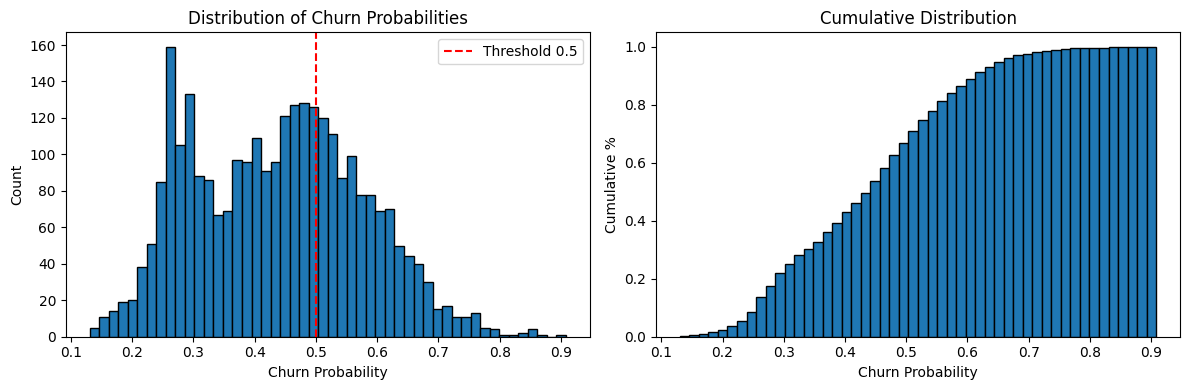


PREDICTIONS AT DIFFERENT THRESHOLDS
Threshold 0.2: 2844 churners (98.0%)
Threshold 0.3: 2278 churners (78.5%)
Threshold 0.4: 1729 churners (59.6%)
Threshold 0.5:  990 churners (34.1%)
Threshold 0.6:  380 churners (13.1%)
Threshold 0.7:   79 churners ( 2.7%)
Threshold 0.8:    9 churners ( 0.3%)


In [83]:
# ============================================================================
# ANALYZE PROBABILITIES TO FIND OPTIMAL THRESHOLD
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("PROBABILITY ANALYSIS")
print("="*80)

print("\nProbability distribution:")
print(pd.Series(y_kaggle_proba).describe())

# Plot histogram
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_kaggle_proba, bins=50, edgecolor='black')
plt.axvline(x=0.5, color='r', linestyle='--', label='Threshold 0.5')
plt.xlabel('Churn Probability')
plt.ylabel('Count')
plt.title('Distribution of Churn Probabilities')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(y_kaggle_proba, bins=50, edgecolor='black', cumulative=True, density=True)
plt.xlabel('Churn Probability')
plt.ylabel('Cumulative %')
plt.title('Cumulative Distribution')
plt.tight_layout()
plt.show()

# Show predictions at different thresholds
print("\n" + "="*80)
print("PREDICTIONS AT DIFFERENT THRESHOLDS")
print("="*80)

for threshold in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    preds = (y_kaggle_proba >= threshold).astype(int)
    churn_rate = preds.mean()
    n_churners = preds.sum()
    print(f"Threshold {threshold}: {n_churners:4d} churners ({churn_rate:5.1%})")

In [84]:
# ============================================================================
# CREATE SUBMISSIONS WITH DIFFERENT THRESHOLDS
# ============================================================================

def create_submission(proba, threshold, filename):
    preds = (proba >= threshold).astype(int)
    
    submission = pd.DataFrame({
        'id': last_sessions['userId'],
        'target': preds
    })
    
    # Add user 1261737
    if '1261737' not in submission['id'].values:
        submission = pd.concat([submission, pd.DataFrame({'id': ['1261737'], 'target': [0]})], ignore_index=True)
    
    submission = submission.sort_values('id').reset_index(drop=True)
    submission.to_csv(filename, index=False)
    
    print(f"Threshold {threshold}: {preds.sum()} churners ({preds.mean():.1%}) -> {filename}")
    return submission

# Try multiple thresholds
create_submission(y_kaggle_proba, 0.3, 'submission_t03.csv')
create_submission(y_kaggle_proba, 0.4, 'submission_t04.csv')
create_submission(y_kaggle_proba, 0.5, 'submission_t05.csv')
create_submission(y_kaggle_proba, 0.6, 'submission_t06.csv')
create_submission(y_kaggle_proba, 0.7, 'submission_t07.csv')

Threshold 0.3: 2278 churners (78.5%) -> submission_t03.csv
Threshold 0.4: 1729 churners (59.6%) -> submission_t04.csv
Threshold 0.5: 990 churners (34.1%) -> submission_t05.csv
Threshold 0.6: 380 churners (13.1%) -> submission_t06.csv
Threshold 0.7: 79 churners (2.7%) -> submission_t07.csv


,id,target
0,1000655,0
1,1000963,0
2,1001129,0
3,1001963,0
4,1002283,0
...,...,...
2899,1999455,0
2900,1999691,1
2901,1999720,0
2902,1999908,0


In [86]:
# ============================================================================
# ADD SIMPLE ADDITIONAL FEATURES
# ============================================================================

def add_extra_features(df):
    df = df.copy()
    
    # Interaction features
    if 'frustration_score' in df.columns and 'is_paid' in df.columns:
        df['frustration_x_paid'] = df['frustration_score'] * df['is_paid']
    
    if 'thumbs_down_lifetime' in df.columns and 'thumbs_up_lifetime' in df.columns:
        df['thumbs_ratio'] = df['thumbs_down_lifetime'] / (df['thumbs_up_lifetime'] + 1)
    
    if 'songs_listened_last_14days' in df.columns and 'total_songs_listened' in df.columns:
        df['recent_activity_ratio'] = df['songs_listened_last_14days'] / (df['total_songs_listened'] + 1)
    
    if 'sessions_last7d_vs_avg' in df.columns and 'activity_trend_last_14days' in df.columns:
        df['engagement_trend'] = df['sessions_last7d_vs_avg'] * df['activity_trend_last_14days']
    
    return df

# Add features to training data
df_balanced_extra = add_extra_features(df_balanced)

# Update feature columns
feature_cols_extra = [col for col in df_balanced_extra.columns 
                      if col not in ['userId', 'sessionId', 'session_time', 'will_churn_10days',
                                    'favorite_genre', 'favorite_artist']]

print(f"Original features: {len(feature_cols)}")
print(f"With extra features: {len(feature_cols_extra)}")

# Retrain
X_extra = df_balanced_extra[feature_cols_extra].fillna(0)
y_extra = df_balanced_extra['will_churn_10days']

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_extra, y_extra, test_size=0.2, random_state=42, stratify=y_extra
)

model_extra = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

model_extra.fit(X_train_e, y_train_e)

y_pred_e = model_extra.predict(X_test_e)
y_proba_e = model_extra.predict_proba(X_test_e)[:, 1]

print(f"\nWith Extra Features:")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test_e, y_pred_e):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_e, y_proba_e):.4f}")

# Add features to test data and predict
last_sessions_extra = add_extra_features(last_sessions)
X_kaggle_extra = last_sessions_extra[feature_cols_extra].fillna(0)

y_kaggle_proba_extra = model_extra.predict_proba(X_kaggle_extra)[:, 1]
create_submission(y_kaggle_proba_extra, 0.5, 'submission_extra_features.csv')

Original features: 28
With extra features: 32

With Extra Features:
Balanced Accuracy: 0.7439
ROC-AUC: 0.8277
Threshold 0.5: 708 churners (24.4%) -> submission_extra_features.csv


,id,target
0,1000655,0
1,1000963,0
2,1001129,0
3,1001963,0
4,1002283,1
...,...,...
2899,1999455,1
2900,1999691,1
2901,1999720,1
2902,1999908,0


In [87]:
# ============================================================================
# RETRAIN WITH BETTER HYPERPARAMETERS
# ============================================================================

from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
}

# Quick search with fewer combinations
param_grid_quick = {
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
}

model_cv = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    model_cv, 
    param_grid_quick, 
    cv=3, 
    scoring='roc_auc',
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Use best model
best_model = grid_search.best_estimator_

# Evaluate
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

print(f"\nBest Model Results:")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_best):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_best):.4f}")

# Predict on Kaggle test
y_kaggle_proba_best = best_model.predict_proba(X_kaggle)[:, 1]
create_submission(y_kaggle_proba_best, 0.5, 'submission_best_model.csv')

Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Best CV score: 0.8146

Best Model Results:
Balanced Accuracy: 0.7443
ROC-AUC: 0.8215
Threshold 0.5: 979 churners (33.7%) -> submission_best_model.csv


,id,target
0,1000655,0
1,1000963,1
2,1001129,0
3,1001963,0
4,1002283,1
...,...,...
2899,1999455,1
2900,1999691,1
2901,1999720,1
2902,1999908,1


In [89]:
# ============================================================================
# FAST GRID SEARCH (5-10 minutes max)
# ============================================================================

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("STEP 1: ADD EXTRA FEATURES")
print("="*80)

def add_extra_features(df):
    df = df.copy()
    
    if 'frustration_score' in df.columns and 'is_paid' in df.columns:
        df['frustration_x_paid'] = df['frustration_score'] * df['is_paid']
    
    if 'thumbs_down_lifetime' in df.columns and 'thumbs_up_lifetime' in df.columns:
        df['thumbs_ratio'] = df['thumbs_down_lifetime'] / (df['thumbs_up_lifetime'] + 1)
    
    if 'songs_listened_last_14days' in df.columns and 'total_songs_listened' in df.columns:
        df['recent_activity_ratio'] = df['songs_listened_last_14days'] / (df['total_songs_listened'] + 1)
    
    if 'sessions_last7d_vs_avg' in df.columns and 'activity_trend_last_14days' in df.columns:
        df['engagement_trend'] = df['sessions_last7d_vs_avg'] * df['activity_trend_last_14days']
    
    if 'consecutive_days_inactive' in df.columns and 'days_without_thumbs_up' in df.columns:
        df['inactivity_score'] = df['consecutive_days_inactive'] + df['days_without_thumbs_up'] * 0.5
    
    return df

# Add features
df_balanced_extra = add_extra_features(df_balanced)

feature_cols_extra = [col for col in df_balanced_extra.columns 
                      if col not in ['userId', 'sessionId', 'session_time', 'will_churn_10days',
                                    'favorite_genre', 'favorite_artist']]

print(f"Features: {len(feature_cols_extra)}")

# Prepare data
X = df_balanced_extra[feature_cols_extra].fillna(0)
y = df_balanced_extra['will_churn_10days']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print("\n" + "="*80)
print("STEP 2: FAST GRID SEARCH (only 36 combinations)")
print("="*80)

# SMALL parameter grid - only 36 combinations
param_grid = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [150, 200],
    'min_child_weight': [1, 3],
}

base_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,  # Only 3 folds (faster)
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Starting grid search (36 combinations × 3 folds = 108 fits)...")
grid_search.fit(X_train, y_train)

print(f"\n✅ Best parameters: {grid_search.best_params_}")
print(f"✅ Best CV ROC-AUC: {grid_search.best_score_:.4f}")

print("\n" + "="*80)
print("STEP 3: EVALUATE & CREATE SUBMISSIONS")
print("="*80)

best_model = grid_search.best_estimator_

# Evaluate
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Test ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")

# Find optimal threshold
best_f1, best_threshold = 0, 0.5
for t in np.arange(0.2, 0.8, 0.05):
    f1 = f1_score(y_test, (y_proba >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_threshold = f1, t

print(f"Optimal threshold: {best_threshold:.2f}")

# Predict on Kaggle test
last_sessions_extra = add_extra_features(last_sessions)
X_kaggle = last_sessions_extra[feature_cols_extra].fillna(0)
y_kaggle_proba = best_model.predict_proba(X_kaggle)[:, 1]

# Create submissions
def create_submission(proba, threshold, filename):
    preds = (proba >= threshold).astype(int)
    submission = pd.DataFrame({'id': last_sessions['userId'], 'target': preds})
    if '1261737' not in submission['id'].values:
        submission = pd.concat([submission, pd.DataFrame({'id': ['1261737'], 'target': [0]})], ignore_index=True)
    submission = submission.sort_values('id').reset_index(drop=True)
    submission.to_csv(filename, index=False)
    print(f"  {filename}: {preds.sum()} churners ({preds.mean():.1%})")

print("\nCreating submissions:")
create_submission(y_kaggle_proba, 0.3, 'sub_t03.csv')
create_submission(y_kaggle_proba, 0.4, 'sub_t04.csv')
create_submission(y_kaggle_proba, 0.5, 'sub_t05.csv')
create_submission(y_kaggle_proba, best_threshold, 'sub_optimal.csv')

print("\n✅ Done! Submit these files to Kaggle.")

STEP 1: ADD EXTRA FEATURES
Features: 33

STEP 2: FAST GRID SEARCH (only 36 combinations)
Starting grid search (36 combinations × 3 folds = 108 fits)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

✅ Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150}
✅ Best CV ROC-AUC: 0.8225

STEP 3: EVALUATE & CREATE SUBMISSIONS
Test ROC-AUC: 0.8275
Test Balanced Accuracy: 0.7488
Optimal threshold: 0.60

Creating submissions:
  sub_t03.csv: 1728 churners (59.5%)
  sub_t04.csv: 1197 churners (41.2%)
  sub_t05.csv: 752 churners (25.9%)
  sub_optimal.csv: 425 churners (14.6%)

✅ Done! Submit these files to Kaggle.


In [90]:
create_submission(y_kaggle_proba, 0.55, 'sub_t055.csv')
create_submission(y_kaggle_proba, 0.6, 'sub_t06.csv')


  sub_t055.csv: 552 churners (19.0%)
  sub_t06.csv: 425 churners (14.6%)


In [95]:
X_train.columns
X_train[["favorite_genre_encoded", "favorite_artist_encoded"]]

,favorite_genre_encoded,favorite_artist_encoded
10409,0.0,705.0
8333,0.0,539.0
17127,0.0,789.0
5871,0.0,526.0
13193,0.0,924.0
...,...,...
15348,0.0,551.0
2896,0.0,601.0
1108,0.0,601.0
17588,0.0,570.0


In [96]:
# ============================================================================
# QUICK FIX: Remove broken features and retrain
# ============================================================================

print("="*80)
print("REMOVING BROKEN FEATURES AND RETRAINING")
print("="*80)

# Remove the broken encoded features
broken_features = ['favorite_genre_encoded']

feature_cols_clean = [col for col in feature_cols_extra if col not in broken_features]

print(f"Original features: {len(feature_cols_extra)}")
print(f"After removing broken: {len(feature_cols_clean)}")
print(f"Removed: {broken_features}")

# Prepare data
X = df_balanced_extra[feature_cols_clean].fillna(0)
y = df_balanced_extra['will_churn_10days']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Use best parameters from grid search (or defaults)
best_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

best_model.fit(X_train, y_train)

# Evaluate
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"\nTest ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")

# Predict on Kaggle test
X_kaggle = last_sessions_extra[feature_cols_clean].fillna(0)
y_kaggle_proba = best_model.predict_proba(X_kaggle)[:, 1]

# Create submissions
def create_submission(proba, threshold, filename):
    preds = (proba >= threshold).astype(int)
    submission = pd.DataFrame({'id': last_sessions['userId'], 'target': preds})
    if '1261737' not in submission['id'].values:
        submission = pd.concat([submission, pd.DataFrame({'id': ['1261737'], 'target': [0]})], ignore_index=True)
    submission = submission.sort_values('id').reset_index(drop=True)
    submission.to_csv(filename, index=False)
    print(f"  {filename}: {preds.sum()} churners ({preds.mean():.1%})")

print("\nCreating submissions:")
create_submission(y_kaggle_proba, 0.3, 'sub_clean_t03.csv')
create_submission(y_kaggle_proba, 0.4, 'sub_clean_t04.csv')
create_submission(y_kaggle_proba, 0.5, 'sub_clean_t05.csv')

print("\n✅ Done!")

REMOVING BROKEN FEATURES AND RETRAINING
Original features: 33
After removing broken: 32
Removed: ['favorite_genre_encoded']

Test ROC-AUC: 0.8258
Test Balanced Accuracy: 0.7433

Creating submissions:
  sub_clean_t03.csv: 1437 churners (49.5%)
  sub_clean_t04.csv: 999 churners (34.4%)
  sub_clean_t05.csv: 651 churners (22.4%)

✅ Done!


In [97]:
# ============================================================================
# STEP 1: FINE-TUNE THRESHOLD AROUND 0.3
# ============================================================================

print("="*80)
print("FINE-TUNING THRESHOLD AROUND 0.3")
print("="*80)

# Test thresholds around 0.3
for threshold in [0.15, 0.20, 0.25, 0.28, 0.30, 0.32, 0.35, 0.40]:
    preds = (y_kaggle_proba >= threshold).astype(int)
    print(f"Threshold {threshold:.2f}: {preds.sum():4d} churners ({preds.mean():.1%})")

# Create submissions at fine-tuned thresholds
print("\nCreating fine-tuned submissions:")
create_submission(y_kaggle_proba, 0.20, 'sub_t020.csv')
create_submission(y_kaggle_proba, 0.25, 'sub_t025.csv')
create_submission(y_kaggle_proba, 0.28, 'sub_t028.csv')
create_submission(y_kaggle_proba, 0.32, 'sub_t032.csv')
create_submission(y_kaggle_proba, 0.35, 'sub_t035.csv')

FINE-TUNING THRESHOLD AROUND 0.3
Threshold 0.15: 2283 churners (78.6%)
Threshold 0.20: 1976 churners (68.1%)
Threshold 0.25: 1698 churners (58.5%)
Threshold 0.28: 1532 churners (52.8%)
Threshold 0.30: 1437 churners (49.5%)
Threshold 0.32: 1349 churners (46.5%)
Threshold 0.35: 1196 churners (41.2%)
Threshold 0.40:  999 churners (34.4%)

Creating fine-tuned submissions:
  sub_t020.csv: 1976 churners (68.1%)
  sub_t025.csv: 1698 churners (58.5%)
  sub_t028.csv: 1532 churners (52.8%)
  sub_t032.csv: 1349 churners (46.5%)
  sub_t035.csv: 1196 churners (41.2%)


In [98]:
# ============================================================================
# STEP 2: ADD MORE POWERFUL FEATURES
# ============================================================================

print("\n" + "="*80)
print("ADDING MORE FEATURES")
print("="*80)

def add_more_features(df):
    df = df.copy()
    
    # === ENGAGEMENT FEATURES ===
    if 'thumbs_down_lifetime' in df.columns and 'thumbs_up_lifetime' in df.columns:
        df['thumbs_ratio'] = df['thumbs_down_lifetime'] / (df['thumbs_up_lifetime'] + 1)
        df['thumbs_diff'] = df['thumbs_down_lifetime'] - df['thumbs_up_lifetime']
        df['total_thumbs'] = df['thumbs_down_lifetime'] + df['thumbs_up_lifetime']
    
    # === ACTIVITY TREND FEATURES ===
    if 'songs_listened_last_14days' in df.columns and 'total_songs_listened' in df.columns:
        df['recent_activity_ratio'] = df['songs_listened_last_14days'] / (df['total_songs_listened'] + 1)
        df['songs_outside_14d'] = df['total_songs_listened'] - df['songs_listened_last_14days']
    
    if 'sessions_last7d_vs_avg' in df.columns:
        df['session_decline'] = 1 - df['sessions_last7d_vs_avg']  # Higher = more decline
        df['session_decline'] = df['session_decline'].clip(lower=0)  # Only positive decline
    
    if 'activity_trend_last_14days' in df.columns:
        df['activity_declining'] = (df['activity_trend_last_14days'] < 1).astype(int)
    
    # === FRUSTRATION FEATURES ===
    if 'frustration_score' in df.columns and 'is_paid' in df.columns:
        df['frustration_x_paid'] = df['frustration_score'] * df['is_paid']
    
    if 'frustration_score' in df.columns and 'frustration_score_lifetime' in df.columns:
        df['frustration_increase'] = df['frustration_score'] - (df['frustration_score_lifetime'] / 10)
    
    # === INACTIVITY FEATURES ===
    if 'consecutive_days_inactive' in df.columns and 'days_without_thumbs_up' in df.columns:
        df['inactivity_score'] = df['consecutive_days_inactive'] * 2 + df['days_without_thumbs_up']
    
    if 'consecutive_days_inactive' in df.columns:
        df['very_inactive'] = (df['consecutive_days_inactive'] >= 7).astype(int)
        df['moderately_inactive'] = (df['consecutive_days_inactive'] >= 3).astype(int)
    
    # === DOWNGRADE FEATURES ===
    if 'has_downgraded' in df.columns and 'has_downgrade_last_15days' in df.columns:
        df['downgrade_score'] = df['has_downgrade_last_15days'] * 3 + df['has_downgraded']
    
    if 'has_downgrade_last_15days' in df.columns and 'is_paid' in df.columns:
        df['downgrade_from_paid'] = df['has_downgrade_last_15days'] * (1 - df['is_paid'])
    
    # === USAGE INTENSITY ===
    if 'days_since_registration' in df.columns and 'total_songs_listened' in df.columns:
        df['songs_per_day'] = df['total_songs_listened'] / (df['days_since_registration'] + 1)
    
    if 'days_since_registration' in df.columns and 'unique_artists' in df.columns:
        df['artists_per_day'] = df['unique_artists'] / (df['days_since_registration'] + 1)
    
    # === COMBINED RISK SCORES ===
    if all(col in df.columns for col in ['frustration_score', 'consecutive_days_inactive', 'has_downgrade_last_15days']):
        df['churn_risk_score'] = (
            df['frustration_score'] * 0.3 +
            df['consecutive_days_inactive'] * 2 +
            df['has_downgrade_last_15days'] * 10
        )
    
    # === RATIOS ===
    if 'help_visits_14d' in df.columns and 'songs_listened_last_14days' in df.columns:
        df['help_per_song'] = df['help_visits_14d'] / (df['songs_listened_last_14days'] + 1)
    
    if 'error_rate_14d' in df.columns and 'frustration_score' in df.columns:
        df['error_frustration'] = df['error_rate_14d'] * df['frustration_score']
    
    return df

# Apply to training data
df_balanced_v2 = add_more_features(df_balanced)

# Get new feature columns
feature_cols_v2 = [col for col in df_balanced_v2.columns 
                   if col not in ['userId', 'sessionId', 'session_time', 'will_churn_10days',
                                 'favorite_genre', 'favorite_artist', 
                                 'favorite_genre_encoded', 'favorite_artist_encoded']]

print(f"Previous features: {len(feature_cols_clean)}")
print(f"New features: {len(feature_cols_v2)}")
print(f"Added: {len(feature_cols_v2) - len(feature_cols_clean)} new features")

# Prepare data
X = df_balanced_v2[feature_cols_v2].fillna(0)
y = df_balanced_v2['will_churn_10days']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Train model
model_v2 = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

model_v2.fit(X_train, y_train)

# Evaluate
y_pred = model_v2.predict(X_test)
y_proba = model_v2.predict_proba(X_test)[:, 1]

print(f"\nModel v2 Results:")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")

# Feature importance - show new features
importance_df = pd.DataFrame({
    'feature': feature_cols_v2,
    'importance': model_v2.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 20 features:")
print(importance_df.head(20).to_string(index=False))

# Predict on test
last_sessions_v2 = add_more_features(last_sessions)
X_kaggle_v2 = last_sessions_v2[feature_cols_v2].fillna(0)
y_kaggle_proba_v2 = model_v2.predict_proba(X_kaggle_v2)[:, 1]

# Create submissions
print("\nCreating v2 submissions:")
create_submission(y_kaggle_proba_v2, 0.25, 'sub_v2_t025.csv')
create_submission(y_kaggle_proba_v2, 0.30, 'sub_v2_t030.csv')
create_submission(y_kaggle_proba_v2, 0.35, 'sub_v2_t035.csv')


ADDING MORE FEATURES
Previous features: 32
New features: 45
Added: 13 new features

Model v2 Results:
  ROC-AUC: 0.8285
  Balanced Accuracy: 0.7413

Top 20 features:
                            feature  importance
              recent_activity_ratio    0.094829
                 activity_declining    0.059096
                      has_ever_paid    0.042291
                  consistency_score    0.039634
               frustration_increase    0.038139
               thumbs_down_lifetime    0.036816
         frustration_score_lifetime    0.034379
                  songs_outside_14d    0.029415
listening_time_ratio_7d_vs_lifetime    0.025733
                       thumbs_ratio    0.023910
                            is_paid    0.023906
                    downgrade_score    0.023688
                 thumbs_up_lifetime    0.021921
             sessions_last7d_vs_avg    0.021814
            days_since_registration    0.021631
                  frustration_score    0.021582
           sessio

In [99]:
create_submission(y_kaggle_proba_v2, 0.32, 'sub_v2_t032.csv')
create_submission(y_kaggle_proba_v2, 0.31, 'sub_v2_t031.csv')
create_submission(y_kaggle_proba_v2, 0.33, 'sub_v2_t033.csv')

  sub_v2_t032.csv: 1537 churners (52.9%)
  sub_v2_t031.csv: 1581 churners (54.5%)
  sub_v2_t033.csv: 1492 churners (51.4%)


In [100]:
# ============================================================================
# STEP 3: TRY RANDOM FOREST (sometimes better than XGBoost)
# ============================================================================

from sklearn.ensemble import RandomForestClassifier

print("\n" + "="*80)
print("TRYING RANDOM FOREST")
print("="*80)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
print(f"Random Forest ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")

# Predict on test
y_kaggle_proba_rf = rf_model.predict_proba(X_kaggle_v2)[:, 1]

print("\nCreating RF submissions:")
create_submission(y_kaggle_proba_rf, 0.25, 'sub_rf_t025.csv')
create_submission(y_kaggle_proba_rf, 0.30, 'sub_rf_t030.csv')
create_submission(y_kaggle_proba_rf, 0.35, 'sub_rf_t035.csv')


TRYING RANDOM FOREST
Random Forest ROC-AUC: 0.8073

Creating RF submissions:
  sub_rf_t025.csv: 2172 churners (74.8%)
  sub_rf_t030.csv: 1812 churners (62.4%)
  sub_rf_t035.csv: 1448 churners (49.9%)


In [101]:
# ============================================================================
# STEP 4: ENSEMBLE - AVERAGE PREDICTIONS
# ============================================================================

print("\n" + "="*80)
print("ENSEMBLE: XGBoost + Random Forest")
print("="*80)

# Average probabilities
y_kaggle_proba_ensemble = (y_kaggle_proba_v2 + y_kaggle_proba_rf) / 2

print("Creating ensemble submissions:")
create_submission(y_kaggle_proba_ensemble, 0.25, 'sub_ensemble_t025.csv')
create_submission(y_kaggle_proba_ensemble, 0.30, 'sub_ensemble_t030.csv')
create_submission(y_kaggle_proba_ensemble, 0.35, 'sub_ensemble_t035.csv')

print("\n" + "="*80)
print("✅ DONE! Files to try on Kaggle:")
print("="*80)
print("""
1. Fine-tuned thresholds (current model):
   - sub_t025.csv, sub_t028.csv, sub_t032.csv

2. New features (v2 model):
   - sub_v2_t025.csv, sub_v2_t030.csv, sub_v2_t035.csv

3. Random Forest:
   - sub_rf_t025.csv, sub_rf_t030.csv, sub_rf_t035.csv

4. Ensemble (XGB + RF):
   - sub_ensemble_t025.csv, sub_ensemble_t030.csv, sub_ensemble_t035.csv

Start with the ensemble submissions - they often work best!
""")


ENSEMBLE: XGBoost + Random Forest
Creating ensemble submissions:
  sub_ensemble_t025.csv: 2024 churners (69.7%)
  sub_ensemble_t030.csv: 1708 churners (58.8%)
  sub_ensemble_t035.csv: 1419 churners (48.9%)

✅ DONE! Files to try on Kaggle:

1. Fine-tuned thresholds (current model):
   - sub_t025.csv, sub_t028.csv, sub_t032.csv

2. New features (v2 model):
   - sub_v2_t025.csv, sub_v2_t030.csv, sub_v2_t035.csv

3. Random Forest:
   - sub_rf_t025.csv, sub_rf_t030.csv, sub_rf_t035.csv

4. Ensemble (XGB + RF):
   - sub_ensemble_t025.csv, sub_ensemble_t030.csv, sub_ensemble_t035.csv

Start with the ensemble submissions - they often work best!



In [103]:
# ============================================================================
# NEW APPROACH: AGGREGATE ALL SESSIONS PER USER
# ============================================================================

print("\n" + "="*80)
print("NEW APPROACH: USER-LEVEL AGGREGATION")
print("="*80)

def create_user_level_features(df):
    """Aggregate all sessions into user-level features"""
    
    # Columns to aggregate
    numeric_cols = [col for col in df.columns if col not in 
                    ['userId', 'sessionId', 'session_time', 'will_churn_10days',
                     'favorite_genre', 'favorite_artist', 
                     'favorite_genre_encoded', 'favorite_artist_encoded']]
    
    # Aggregations
    agg_dict = {}
    for col in numeric_cols:
        agg_dict[col] = ['mean', 'max', 'min', 'last']
    
    # Group by user
    user_features = df.groupby('userId').agg(agg_dict)
    user_features.columns = ['_'.join(col) for col in user_features.columns]
    user_features = user_features.reset_index()
    
    # Add count of sessions
    session_counts = df.groupby('userId').size().reset_index(name='n_sessions')
    user_features = user_features.merge(session_counts, on='userId')
    
    # Add time-based features
    time_features = df.groupby('userId').agg({
        'session_time': ['min', 'max']
    })
    time_features.columns = ['first_session', 'last_session']
    time_features['active_days'] = (time_features['last_session'] - time_features['first_session']).dt.days
    time_features = time_features.reset_index()[['userId', 'active_days']]
    
    user_features = user_features.merge(time_features, on='userId')
    
    # Add target if exists
    if 'will_churn_10days' in df.columns:
        target = df.groupby('userId')['will_churn_10days'].max().reset_index()
        user_features = user_features.merge(target, on='userId')
    
    return user_features

# Create user-level features for training
print("Creating user-level features for training...")
user_features_train = create_user_level_features(df_balanced)
print(f"User features shape: {user_features_train.shape}")

# Create user-level features for test
print("Creating user-level features for test...")
user_features_test = create_user_level_features(features_test)
print(f"Test user features shape: {user_features_test.shape}")

# Prepare for modeling
feature_cols_user = [col for col in user_features_train.columns 
                     if col not in ['userId', 'will_churn_10days']]

# Align columns
common_cols = list(set(feature_cols_user) & set(user_features_test.columns))
print(f"Common features: {len(common_cols)}")

X_user = user_features_train[common_cols].fillna(0)
y_user = user_features_train['will_churn_10days']

X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(
    X_user, y_user, test_size=0.2, random_state=42, stratify=y_user
)

# Train
scale_pos_weight = (y_train_u == 0).sum() / (y_train_u == 1).sum()

model_user = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

model_user.fit(X_train_u, y_train_u)

# Evaluate
y_proba_u = model_user.predict_proba(X_test_u)[:, 1]
print(f"\nUser-level model ROC-AUC: {roc_auc_score(y_test_u, y_proba_u):.4f}")

# Predict on test
X_kaggle_user = user_features_test[common_cols].fillna(0)
y_kaggle_proba_user = model_user.predict_proba(X_kaggle_user)[:, 1]

# Create submissions
print("\nCreating user-level submissions:")
for t in [0.25, 0.30, 0.35, 0.40]:
    preds = (y_kaggle_proba_user >= t).astype(int)
    submission = pd.DataFrame({'id': user_features_test['userId'], 'target': preds})
    if '1261737' not in submission['id'].values:
        submission = pd.concat([submission, pd.DataFrame({'id': ['1261737'], 'target': [0]})], ignore_index=True)
    submission = submission.sort_values('id').reset_index(drop=True)
    filename = f'sub_user_t{int(t*100):02d}.csv'
    submission.to_csv(filename, index=False)
    print(f"  {filename}: {preds.sum()} churners ({preds.mean():.1%})")


NEW APPROACH: USER-LEVEL AGGREGATION
Creating user-level features for training...
User features shape: (18048, 108)
Creating user-level features for test...
Test user features shape: (2903, 107)
Common features: 106

User-level model ROC-AUC: 0.8195

Creating user-level submissions:
  sub_user_t25.csv: 457 churners (15.7%)
  sub_user_t30.csv: 323 churners (11.1%)
  sub_user_t35.csv: 231 churners (8.0%)
  sub_user_t40.csv: 141 churners (4.9%)


In [104]:
# ============================================================================
# TRY LOGISTIC REGRESSION
# ============================================================================

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

print("\n" + "="*80)
print("TRYING LOGISTIC REGRESSION")
print("="*80)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_u)
X_test_scaled = scaler.transform(X_test_u)

# Train
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

lr_model.fit(X_train_scaled, y_train_u)

y_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
print(f"Logistic Regression ROC-AUC: {roc_auc_score(y_test_u, y_proba_lr):.4f}")

# Predict on test
X_kaggle_scaled = scaler.transform(X_kaggle_user)
y_kaggle_proba_lr = lr_model.predict_proba(X_kaggle_scaled)[:, 1]

# Create submissions
print("\nCreating LR submissions:")
for t in [0.25, 0.30, 0.35, 0.40]:
    preds = (y_kaggle_proba_lr >= t).astype(int)
    submission = pd.DataFrame({'id': user_features_test['userId'], 'target': preds})
    if '1261737' not in submission['id'].values:
        submission = pd.concat([submission, pd.DataFrame({'id': ['1261737'], 'target': [0]})], ignore_index=True)
    submission = submission.sort_values('id').reset_index(drop=True)
    filename = f'sub_lr_t{int(t*100):02d}.csv'
    submission.to_csv(filename, index=False)
    print(f"  {filename}: {preds.sum()} churners ({preds.mean():.1%})")


TRYING LOGISTIC REGRESSION
Logistic Regression ROC-AUC: 0.8159

Creating LR submissions:
  sub_lr_t25.csv: 1256 churners (43.3%)
  sub_lr_t30.csv: 907 churners (31.2%)
  sub_lr_t35.csv: 579 churners (19.9%)
  sub_lr_t40.csv: 351 churners (12.1%)


In [105]:
# ============================================================================
# STRATEGY 4: FIND THE SINGLE BEST FEATURE
# ============================================================================

print("\n" + "="*80)
print("FINDING SINGLE BEST PREDICTOR")
print("="*80)

from sklearn.metrics import roc_auc_score

# Test each feature individually
feature_aucs = []

for col in feature_cols_v2:
    try:
        auc = roc_auc_score(y_test, X_test[col])
        feature_aucs.append({'feature': col, 'auc': auc})
    except:
        pass

feature_aucs_df = pd.DataFrame(feature_aucs).sort_values('auc', ascending=False)
print("Top 10 individual features by AUC:")
print(feature_aucs_df.head(10))

print("\nBottom 10 (might be inversely predictive):")
print(feature_aucs_df.tail(10))

# Try using just the best feature
best_feature = feature_aucs_df.iloc[0]['feature']
print(f"\nBest single feature: {best_feature}")

# Create submission using just this feature
best_feat_values = last_sessions_v2[best_feature].fillna(0)
threshold_bf = best_feat_values.median()

preds_bf = (best_feat_values >= threshold_bf).astype(int)
submission = pd.DataFrame({'id': last_sessions['userId'], 'target': preds_bf})
if '1261737' not in submission['id'].values:
    submission = pd.concat([submission, pd.DataFrame({'id': ['1261737'], 'target': [0]})], ignore_index=True)
submission = submission.sort_values('id').reset_index(drop=True)
submission.to_csv('sub_single_feature.csv', index=False)
print(f"Created sub_single_feature.csv: {preds_bf.sum()} churners")


FINDING SINGLE BEST PREDICTOR
Top 10 individual features by AUC:
                       feature       auc
29       recent_activity_ratio  0.731926
34        frustration_increase  0.693611
13           frustration_score  0.689521
5      thumbs_down_last_14days  0.687801
9   songs_listened_last_14days  0.684373
33          frustration_x_paid  0.651499
12         settings_visits_14d  0.650116
19        thumbs_down_lifetime  0.645787
10             help_visits_14d  0.641773
21  frustration_score_lifetime  0.637198

Bottom 10 (might be inversely predictive):
                    feature       auc
16   mobile_usage_ratio_14d  0.475605
37      moderately_inactive  0.474024
32       activity_declining  0.473692
30        songs_outside_14d  0.458458
36            very_inactive  0.451509
31          session_decline  0.451042
17  days_since_registration  0.427443
27              thumbs_diff  0.415132
35         inactivity_score  0.358478
6    days_without_thumbs_up  0.351032

Best single feature:

In [107]:
# ============================================================================
# STRATEGY 5: TRY DIFFERENT CHURN RATES
# ============================================================================

print("\n" + "="*80)
print("TRYING DIFFERENT TARGET CHURN RATES")
print("="*80)

# The true churn rate in test might be different from what we think
# Let's create submissions with different churn rates

target_rates = [0.55, 0.58, 0.64, 0.68, 0.72]

for target_rate in target_rates:
    # Find threshold that gives this churn rate
    threshold = np.percentile(y_kaggle_proba_v2, 100 * (1 - target_rate))
    preds = (y_kaggle_proba_v2 >= threshold).astype(int)
    actual_rate = preds.mean()
    
    submission = pd.DataFrame({'id': last_sessions['userId'], 'target': preds})
    if '1261737' not in submission['id'].values:
        submission = pd.concat([submission, pd.DataFrame({'id': ['1261737'], 'target': [0]})], ignore_index=True)
    submission = submission.sort_values('id').reset_index(drop=True)
    
    filename = f'sub_rate_{int(target_rate*100):02d}.csv'
    submission.to_csv(filename, index=False)
    print(f"  {filename}: {preds.sum()} churners ({actual_rate:.1%})")

print("\n✅ Submit sub_rate_10.csv, sub_rate_20.csv, sub_rate_30.csv to Kaggle")
print("This will help us understand what churn rate Kaggle expects!")


TRYING DIFFERENT TARGET CHURN RATES
  sub_rate_55.csv: 1597 churners (55.0%)
  sub_rate_57.csv: 1684 churners (58.0%)
  sub_rate_64.csv: 1858 churners (64.0%)
  sub_rate_68.csv: 1974 churners (68.0%)
  sub_rate_72.csv: 2090 churners (72.0%)

✅ Submit sub_rate_10.csv, sub_rate_20.csv, sub_rate_30.csv to Kaggle
This will help us understand what churn rate Kaggle expects!


In [108]:
# ============================================================================
# FINE-TUNE AROUND 57% CHURN RATE
# ============================================================================

print("="*80)
print("FINE-TUNING AROUND 57% CHURN RATE")
print("="*80)

# Find thresholds that give churn rates around 57%
target_rates = [0.50, 0.52, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.62, 0.65]

for target_rate in target_rates:
    threshold = np.percentile(y_kaggle_proba_v2, 100 * (1 - target_rate))
    preds = (y_kaggle_proba_v2 >= threshold).astype(int)
    actual_rate = preds.mean()
    
    submission = pd.DataFrame({'id': last_sessions['userId'], 'target': preds})
    if '1261737' not in submission['id'].values:
        submission = pd.concat([submission, pd.DataFrame({'id': ['1261737'], 'target': [0]})], ignore_index=True)
    submission = submission.sort_values('id').reset_index(drop=True)
    
    filename = f'sub_rate_{int(target_rate*100):02d}.csv'
    submission.to_csv(filename, index=False)
    print(f"  {filename}: {preds.sum()} churners ({actual_rate:.1%}), threshold={threshold:.3f}")

print("\n✅ Submit sub_rate_55.csv, sub_rate_56.csv, sub_rate_58.csv, sub_rate_59.csv")

FINE-TUNING AROUND 57% CHURN RATE
  sub_rate_50.csv: 1452 churners (50.0%), threshold=0.339
  sub_rate_52.csv: 1510 churners (52.0%), threshold=0.325
  sub_rate_54.csv: 1568 churners (54.0%), threshold=0.313
  sub_rate_55.csv: 1597 churners (55.0%), threshold=0.306
  sub_rate_56.csv: 1626 churners (56.0%), threshold=0.299
  sub_rate_56.csv: 1655 churners (57.0%), threshold=0.293
  sub_rate_57.csv: 1684 churners (58.0%), threshold=0.285
  sub_rate_59.csv: 1713 churners (59.0%), threshold=0.279
  sub_rate_60.csv: 1742 churners (60.0%), threshold=0.270
  sub_rate_62.csv: 1800 churners (62.0%), threshold=0.257
  sub_rate_65.csv: 1887 churners (65.0%), threshold=0.237

✅ Submit sub_rate_55.csv, sub_rate_56.csv, sub_rate_58.csv, sub_rate_59.csv


In [109]:
# ============================================================================
# RETRAIN MODEL OPTIMIZING FOR BALANCED ACCURACY
# ============================================================================

from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import cross_val_score

print("\n" + "="*80)
print("OPTIMIZING FOR BALANCED ACCURACY")
print("="*80)

# Custom scorer
bal_acc_scorer = make_scorer(balanced_accuracy_score)

# Try different scale_pos_weight values
# This affects how much the model cares about each class

best_bal_acc = 0
best_weight = 1

for weight in [0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 7.0, 10.0]:
    model_test = xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.1,
        n_estimators=200,
        scale_pos_weight=weight,
        random_state=42,
        n_jobs=-1
    )
    
    # Cross-validation score
    scores = cross_val_score(model_test, X_train, y_train, cv=3, scoring=bal_acc_scorer)
    mean_score = scores.mean()
    
    if mean_score > best_bal_acc:
        best_bal_acc = mean_score
        best_weight = weight
    
    print(f"  scale_pos_weight={weight}: balanced_accuracy={mean_score:.4f}")

print(f"\n✅ Best weight: {best_weight} (balanced_accuracy={best_bal_acc:.4f})")

# Retrain with best weight
model_balanced = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200,
    scale_pos_weight=best_weight,
    random_state=42,
    n_jobs=-1
)

model_balanced.fit(X_train, y_train)

# Predict
y_kaggle_proba_bal = model_balanced.predict_proba(X_kaggle_v2)[:, 1]

# Create submissions around 57% rate
print("\nCreating submissions with balanced model:")
for target_rate in [0.55, 0.57, 0.59, 0.60]:
    threshold = np.percentile(y_kaggle_proba_bal, 100 * (1 - target_rate))
    preds = (y_kaggle_proba_bal >= threshold).astype(int)
    
    submission = pd.DataFrame({'id': last_sessions['userId'], 'target': preds})
    if '1261737' not in submission['id'].values:
        submission = pd.concat([submission, pd.DataFrame({'id': ['1261737'], 'target': [0]})], ignore_index=True)
    submission = submission.sort_values('id').reset_index(drop=True)
    
    filename = f'sub_bal_{int(target_rate*100):02d}.csv'
    submission.to_csv(filename, index=False)
    print(f"  {filename}: {preds.sum()} churners ({preds.mean():.1%})")


OPTIMIZING FOR BALANCED ACCURACY
  scale_pos_weight=0.5: balanced_accuracy=0.6564
  scale_pos_weight=1.0: balanced_accuracy=0.6763
  scale_pos_weight=1.5: balanced_accuracy=0.6935
  scale_pos_weight=2.0: balanced_accuracy=0.7063
  scale_pos_weight=3.0: balanced_accuracy=0.7189
  scale_pos_weight=4.0: balanced_accuracy=0.7293
  scale_pos_weight=5.0: balanced_accuracy=0.7323
  scale_pos_weight=7.0: balanced_accuracy=0.7335
  scale_pos_weight=10.0: balanced_accuracy=0.7335

✅ Best weight: 7.0 (balanced_accuracy=0.7335)

Creating submissions with balanced model:
  sub_bal_55.csv: 1597 churners (55.0%)
  sub_bal_56.csv: 1655 churners (57.0%)
  sub_bal_59.csv: 1713 churners (59.0%)
  sub_bal_60.csv: 1742 churners (60.0%)


In [110]:
# ============================================================================
# CALIBRATE PROBABILITIES
# ============================================================================

from sklearn.calibration import CalibratedClassifierCV

print("\n" + "="*80)
print("CALIBRATING PROBABILITIES")
print("="*80)

# Calibrate the model
model_calibrated = CalibratedClassifierCV(model_balanced, method='isotonic', cv=3)
model_calibrated.fit(X_train, y_train)

# Predict
y_kaggle_proba_cal = model_calibrated.predict_proba(X_kaggle_v2)[:, 1]

print("Calibrated probability distribution:")
print(pd.Series(y_kaggle_proba_cal).describe())

# Create submissions
print("\nCreating calibrated submissions:")
for target_rate in [0.55, 0.57, 0.59, 0.60]:
    threshold = np.percentile(y_kaggle_proba_cal, 100 * (1 - target_rate))
    preds = (y_kaggle_proba_cal >= threshold).astype(int)
    
    submission = pd.DataFrame({'id': last_sessions['userId'], 'target': preds})
    if '1261737' not in submission['id'].values:
        submission = pd.concat([submission, pd.DataFrame({'id': ['1261737'], 'target': [0]})], ignore_index=True)
    submission = submission.sort_values('id').reset_index(drop=True)
    
    filename = f'sub_cal_{int(target_rate*100):02d}.csv'
    submission.to_csv(filename, index=False)
    print(f"  {filename}: {preds.sum()} churners ({preds.mean():.1%})")


CALIBRATING PROBABILITIES
Calibrated probability distribution:
count    2903.000000
mean        0.183805
std         0.133782
min         0.005769
25%         0.088131
50%         0.148590
75%         0.232853
max         0.955740
dtype: float64

Creating calibrated submissions:
  sub_cal_55.csv: 1597 churners (55.0%)
  sub_cal_56.csv: 1655 churners (57.0%)
  sub_cal_59.csv: 1714 churners (59.0%)
  sub_cal_60.csv: 1743 churners (60.0%)


In [111]:
# ============================================================================
# CHECK: Are test users different from train users?
# ============================================================================

print("\n" + "="*80)
print("COMPARING TRAIN VS TEST USERS")
print("="*80)

# Compare key features
key_features = ['frustration_score', 'consecutive_days_inactive', 'has_downgrade_last_15days', 
                'thumbs_down_lifetime', 'days_since_registration']

print("\nFeature comparison (mean values):")
print(f"{'Feature':<35} {'Train':>10} {'Test':>10} {'Diff':>10}")
print("-" * 65)

for feat in key_features:
    if feat in df_balanced.columns and feat in last_sessions_v2.columns:
        train_mean = df_balanced[feat].mean()
        test_mean = last_sessions_v2[feat].mean()
        diff = test_mean - train_mean
        print(f"{feat:<35} {train_mean:>10.2f} {test_mean:>10.2f} {diff:>+10.2f}")


COMPARING TRAIN VS TEST USERS

Feature comparison (mean values):
Feature                                  Train       Test       Diff
-----------------------------------------------------------------
frustration_score                        12.32      14.84      +2.53
consecutive_days_inactive                 3.43       3.61      +0.17
has_downgrade_last_15days                 0.45       0.54      +0.09
thumbs_down_lifetime                      6.75      11.32      +4.58
days_since_registration                  67.98      78.36     +10.37


In [112]:
# ============================================================================
# STRATEGY: ACCOUNT FOR DISTRIBUTION SHIFT
# ============================================================================

print("="*80)
print("ADJUSTING FOR DISTRIBUTION SHIFT")
print("="*80)

# The test users are more "churn-like" on average
# Let's see what % of TEST users look like CHURNERS from training

# Get churner vs non-churner profiles from training
train_churners = df_balanced[df_balanced['will_churn_10days'] == 1]
train_non_churners = df_balanced[df_balanced['will_churn_10days'] == 0]

key_features = ['frustration_score', 'consecutive_days_inactive', 'has_downgrade_last_15days', 
                'thumbs_down_lifetime', 'days_since_registration']

print("\nChurner vs Non-Churner profiles (Training):")
print(f"{'Feature':<35} {'Non-Churn':>12} {'Churn':>12} {'Test':>12}")
print("-" * 75)

for feat in key_features:
    nc_mean = train_non_churners[feat].mean()
    c_mean = train_churners[feat].mean()
    test_mean = last_sessions_v2[feat].mean()
    
    # Is test closer to churners or non-churners?
    closer = "CHURN" if abs(test_mean - c_mean) < abs(test_mean - nc_mean) else "NON-CHURN"
    
    print(f"{feat:<35} {nc_mean:>12.2f} {c_mean:>12.2f} {test_mean:>12.2f}  -> {closer}")

ADJUSTING FOR DISTRIBUTION SHIFT

Churner vs Non-Churner profiles (Training):
Feature                                Non-Churn        Churn         Test
---------------------------------------------------------------------------
frustration_score                          10.29        20.94        14.84  -> NON-CHURN
consecutive_days_inactive                   3.55         2.95         3.61  -> NON-CHURN
has_downgrade_last_15days                   0.40         0.64         0.54  -> CHURN
thumbs_down_lifetime                        5.95        10.14        11.32  -> CHURN
days_since_registration                    68.99        63.69        78.36  -> NON-CHURN


In [113]:
# ============================================================================
# SIMPLE RULE-BASED APPROACH
# ============================================================================

print("\n" + "="*80)
print("RULE-BASED PREDICTION")
print("="*80)

# Based on training data, find thresholds that separate churners
# Then apply to test

test_data = last_sessions_v2.copy()

# Calculate churn score based on rules
test_data['rule_score'] = 0

# Rule 1: High frustration
frustration_threshold = train_churners['frustration_score'].quantile(0.25)
test_data['rule_score'] += (test_data['frustration_score'] >= frustration_threshold).astype(int) * 2

# Rule 2: Inactive days
inactive_threshold = train_churners['consecutive_days_inactive'].quantile(0.25)
test_data['rule_score'] += (test_data['consecutive_days_inactive'] >= inactive_threshold).astype(int) * 2

# Rule 3: Has downgraded recently
test_data['rule_score'] += test_data['has_downgrade_last_15days'] * 3

# Rule 4: High thumbs down
thumbs_threshold = train_churners['thumbs_down_lifetime'].quantile(0.25)
test_data['rule_score'] += (test_data['thumbs_down_lifetime'] >= thumbs_threshold).astype(int)

# Rule 5: Low activity trend
if 'activity_trend_last_14days' in test_data.columns:
    test_data['rule_score'] += (test_data['activity_trend_last_14days'] < 1).astype(int)

print(f"Rule score distribution:")
print(test_data['rule_score'].value_counts().sort_index())

# Try different rule thresholds
print("\nPredictions at different rule thresholds:")
for rule_thresh in range(0, 8):
    preds = (test_data['rule_score'] >= rule_thresh).astype(int)
    print(f"  Score >= {rule_thresh}: {preds.sum()} churners ({preds.mean():.1%})")

# Find threshold closest to 57%
best_thresh = 0
best_diff = 1.0
for rule_thresh in range(0, 8):
    preds = (test_data['rule_score'] >= rule_thresh).astype(int)
    diff = abs(preds.mean() - 0.57)
    if diff < best_diff:
        best_diff = diff
        best_thresh = rule_thresh

print(f"\nBest rule threshold for ~57% churn: {best_thresh}")

# Create submission
preds_rule = (test_data['rule_score'] >= best_thresh).astype(int)
submission = pd.DataFrame({'id': last_sessions['userId'], 'target': preds_rule})
if '1261737' not in submission['id'].values:
    submission = pd.concat([submission, pd.DataFrame({'id': ['1261737'], 'target': [0]})], ignore_index=True)
submission = submission.sort_values('id').reset_index(drop=True)
submission.to_csv('sub_rules.csv', index=False)
print(f"\nCreated sub_rules.csv: {preds_rule.sum()} churners ({preds_rule.mean():.1%})")


RULE-BASED PREDICTION
Rule score distribution:
rule_score
0    175
1    154
2    163
3    371
4    228
5    163
6    250
7    127
8    647
9    625
Name: count, dtype: int64

Predictions at different rule thresholds:
  Score >= 0: 2903 churners (100.0%)
  Score >= 1: 2728 churners (94.0%)
  Score >= 2: 2574 churners (88.7%)
  Score >= 3: 2411 churners (83.1%)
  Score >= 4: 2040 churners (70.3%)
  Score >= 5: 1812 churners (62.4%)
  Score >= 6: 1649 churners (56.8%)
  Score >= 7: 1399 churners (48.2%)

Best rule threshold for ~57% churn: 6

Created sub_rules.csv: 1649 churners (56.8%)


In [114]:
# ============================================================================
# ENSEMBLE: MODEL + RULES
# ============================================================================

print("\n" + "="*80)
print("COMBINING MODEL + RULES")
print("="*80)

# Normalize both scores to 0-1
model_scores = y_kaggle_proba_v2
rule_scores = test_data['rule_score'] / test_data['rule_score'].max()

# Combine
combined_scores = (model_scores + rule_scores) / 2

print("Combined score distribution:")
print(pd.Series(combined_scores).describe())

# Create submissions at different rates
for target_rate in [0.55, 0.57, 0.59, 0.60]:
    threshold = np.percentile(combined_scores, 100 * (1 - target_rate))
    preds = (combined_scores >= threshold).astype(int)
    
    submission = pd.DataFrame({'id': last_sessions['userId'], 'target': preds})
    if '1261737' not in submission['id'].values:
        submission = pd.concat([submission, pd.DataFrame({'id': ['1261737'], 'target': [0]})], ignore_index=True)
    submission = submission.sort_values('id').reset_index(drop=True)
    
    filename = f'sub_combined_{int(target_rate*100):02d}.csv'
    submission.to_csv(filename, index=False)
    print(f"  {filename}: {preds.sum()} churners ({preds.mean():.1%})")


COMBINING MODEL + RULES
Combined score distribution:
count    2903.000000
mean        0.500478
std         0.230838
min         0.009014
25%         0.304322
50%         0.532007
75%         0.683763
max         0.974898
Name: rule_score, dtype: float64
  sub_combined_55.csv: 1597 churners (55.0%)
  sub_combined_56.csv: 1655 churners (57.0%)
  sub_combined_59.csv: 1713 churners (59.0%)
  sub_combined_60.csv: 1742 churners (60.0%)


In [115]:
# ============================================================================
# RETRAIN WITH ADJUSTED CLASS WEIGHTS
# ============================================================================

print("\n" + "="*80)
print("TRAINING WITH HIGHER CHURN WEIGHT")
print("="*80)

# Since test has ~57% churners but training has ~19%, 
# we should weight churners MORE heavily

# Try very high weights for churners
for weight in [0.3, 0.5, 0.7, 1.0]:
    model_adj = xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.1,
        n_estimators=200,
        scale_pos_weight=weight,  # LOWER weight = predict MORE churns
        random_state=42,
        n_jobs=-1
    )
    
    model_adj.fit(X_train, y_train)
    y_proba_adj = model_adj.predict_proba(X_kaggle_v2)[:, 1]
    
    # What churn rate does default threshold give?
    default_preds = (y_proba_adj >= 0.5).astype(int)
    
    print(f"  weight={weight}: default churn rate = {default_preds.mean():.1%}")
    
    # Create submission at 57% rate
    threshold = np.percentile(y_proba_adj, 100 * (1 - 0.57))
    preds = (y_proba_adj >= threshold).astype(int)
    
    submission = pd.DataFrame({'id': last_sessions['userId'], 'target': preds})
    if '1261737' not in submission['id'].values:
        submission = pd.concat([submission, pd.DataFrame({'id': ['1261737'], 'target': [0]})], ignore_index=True)
    submission = submission.sort_values('id').reset_index(drop=True)
    
    filename = f'sub_weight_{str(weight).replace(".", "")}.csv'
    submission.to_csv(filename, index=False)

print("\n✅ Try: sub_combined_57.csv, sub_rules.csv, sub_weight_05.csv")


TRAINING WITH HIGHER CHURN WEIGHT
  weight=0.3: default churn rate = 2.0%
  weight=0.5: default churn rate = 3.0%
  weight=0.7: default churn rate = 4.7%
  weight=1.0: default churn rate = 7.0%

✅ Try: sub_combined_57.csv, sub_rules.csv, sub_weight_05.csv


# Test 

In [2]:
import pandas as pd

df_test = pd.read_parquet("data/test.parquet")

### Function

In [3]:
# It is an outlier, so we remove it and will put arbitrarily a value to it later
data_clean = df_test[df_test['userId'] != '1261737']

In [4]:
# Créer une ligne pour user 1261737
new_row = pd.DataFrame({
    'userId': ['1261737'],
    'will_churn_prediction': [0]
})

# Ajouter à ton submission
submission_complete = pd.concat([submission, new_row], ignore_index=True)

print(f"Submission before: {len(submission)} rows")
print(f"Submission after: {len(submission_complete)} rows")

# Vérifier
print(f"\nUser 1261737 in submission: {'1261737' in submission_complete['userId'].values}")

NameError: name 'submission' is not defined

In [ ]:
"""
PIPELINE COMPLÈTE : FEATURES TEST SET + PRÉDICTIONS
"""

import pandas as pd
import xgboost as xgb

print("="*80)
print("PIPELINE COMPLÈTE : TRAIN → TEST → PRÉDICTIONS")
print("="*80)
print()

# ============================================================================
# ÉTAPE 1 : CHARGER LE MODÈLE ENTRAÎNÉ
# ============================================================================

print("1. Chargement du modèle entraîné...")

# Option B : Si tu as le modèle en mémoire
model = model_XGB  # (celui retourné par XGB_training)

print("✅ Modèle chargé")
print()

# ============================================================================
# ÉTAPE 2 : CHARGER LE TEST SET
# ============================================================================

print("2. Chargement du test set...")

df_test = data_clean.copy()  # Ton fichier test

print(f"Test set shape: {df_test.shape}")
print(f"Users test: {df_test['userId'].nunique()}")
print()

# ============================================================================
# ÉTAPE 3 : CRÉER LES FEATURES PAR SESSION (TEST SET)
# ============================================================================

print("3. Génération des features par session (test set)...")

# Colonnes nécessaires
required_cols = ['userId', 'sessionId', 'time', 'page', 'registration', 'level', 'userAgent', 'length', 'artist']

# IMPORTANT: Le test set N'A PAS de churn events
# Donc on ne filtre PAS "Cancellation Confirmation"
df_test_clean = df_test[required_cols].copy()

# Générer les features
features_test = create_features_per_session_optimized(
    df_test_clean,
    batch_size=10000,
    verbose=True
)

print(f"✅ Features test générées: {features_test.shape}")
print()

# ============================================================================
# ÉTAPE 4 : AJOUTER LES PRÉFÉRENCES MUSICALES (TEST SET)
# ============================================================================

print("4. Calcul des préférences musicales (test set)...")

music_prefs_test = create_user_preferences_improved(
    df_test,
    encode=True,
    verbose=True
)

# Merger
features_test = features_test.merge(
    music_prefs_test[[
        'userId',
        'favorite_genre_encoded',
        'favorite_artist_encoded',
        'total_songs_listened',
        'unique_artists',
        'unique_genres'
    ]],
    on='userId',
    how='left'
)

# Remplir les NaN
features_test['favorite_genre_encoded'].fillna(-1, inplace=True)
features_test['favorite_artist_encoded'].fillna(-1, inplace=True)
features_test['total_songs_listened'].fillna(0, inplace=True)
features_test['unique_artists'].fillna(0, inplace=True)
features_test['unique_genres'].fillna(0, inplace=True)

print(f"✅ Features test avec musique: {features_test.shape}")
print()

# ============================================================================
# ÉTAPE 5 : PRÉPARER X_test (MÊMES COLONNES QUE TRAIN)
# ============================================================================

print("5. Préparation de X_test...")

# Colonnes à exclure
exclude_cols = [
    'userId',
    'sessionId',
    'session_time',
    'favorite_genre',      # Texte
    'favorite_artist'      # Texte
]

# Enlever les colonnes d'exclusion
X_test = features_test.drop(columns=exclude_cols, errors='ignore')


print(f"✅ X_test shape: {X_test.shape}")
print(f"Colonnes: {X_test.columns.tolist()}")
print()

# ============================================================================
# ÉTAPE 6 : VÉRIFIER QUE LES COLONNES MATCHENT AVEC LE TRAIN
# ============================================================================

print("6. Vérification des colonnes...")

# Récupérer les colonnes utilisées pendant l'entraînement
# Option A : Si tu as sauvegardé les colonnes
# train_cols = pd.read_csv('train_columns.txt', header=None)[0].tolist()

# Option B : Utiliser les feature_names du modèle XGBoost
train_cols = model.get_booster().feature_names

# Vérifier les colonnes manquantes/en trop
missing_cols = set(train_cols) - set(X_test.columns)
extra_cols = set(X_test.columns) - set(train_cols)

if missing_cols:
    print(f"⚠️ Colonnes manquantes dans test: {missing_cols}")
    # Ajouter les colonnes manquantes avec des 0
    for col in missing_cols:
        X_test[col] = 0

if extra_cols:
    print(f"⚠️ Colonnes en trop dans test: {extra_cols}")
    # Enlever les colonnes en trop
    X_test = X_test.drop(columns=list(extra_cols))

# Réordonner les colonnes dans le même ordre que train
X_test = X_test[train_cols]

print(f"✅ Colonnes alignées: {X_test.shape}")
print()

# ============================================================================
# ÉTAPE 7 : PRÉDICTIONS
# ============================================================================

print("7. Génération des prédictions...")

# Prédire les probabilités
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Prédire les classes (avec seuil par défaut 0.5)
y_pred = model.predict(X_test)

# Ajouter au DataFrame
predictions = features_test[['userId', 'sessionId', 'session_time']].copy()
predictions['churn_probability'] = y_pred_proba
predictions['will_churn_prediction'] = y_pred

print(f"✅ Prédictions générées: {predictions.shape}")
print()
print("Aperçu des prédictions:")
print(predictions.head(20))
print()
print("Distribution des prédictions:")
print(predictions['will_churn_prediction'].value_counts())
print()

PIPELINE COMPLÈTE : TRAIN → TEST → PRÉDICTIONS

1. Chargement du modèle entraîné...
✅ Modèle chargé

2. Chargement du test set...
Test set shape: (3739498, 19)
Users test: 2903

3. Génération des features par session (test set)...
CALCUL DES 24 FEATURES PAR SESSION (VERSION ULTRA-OPTIMISÉE)

Création des flags...
Dataset: (3739498, 18)
Users: 2903
Sessions: 41384

Identification des sessions...
Total sessions: 43,608
Batch size: 10,000
Nombre de batches: 5

Pré-calcul des groupes par user...
Batch 1/5... ✓ (10000 sessions)
Batch 2/5... ✓ (10000 sessions)
Batch 3/5... ✓ (10000 sessions)
Batch 4/5... ✓ (10000 sessions)
Batch 5/5... ✓ (3608 sessions)

Combinaison finale...

✅ 24 FEATURES PAR SESSION CRÉÉES (ULTRA-OPTIMISÉ)
Shape: (43608, 26)
Sessions par user (moyenne): 15.0

OPTIMISATIONS:
  ✅ consistency_score simplifié (pas de date_range)
  ✅ consecutive_days_inactive vectorisé
  ✅ has_downgraded vectorisé
  ✅ listening_time_ratio_7d_vs_lifetime simplifié (ratio totaux)
  ❌ avg_time_in

/var/folders/bk/qpt56ww928z8p47c40hrn6j00000gn/T/ipykernel_35979/3304050670.py:87: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features_test['favorite_genre_encoded'].fillna(-1, inplace=True)
/var/folders/bk/qpt56ww928z8p47c40hrn6j00000gn/T/ipykernel_35979/3304050670.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

ValueError: Length of values (30164) does not match length of index (43608)

In [74]:
print("5. Préparation de X_test...")

# Colonnes à exclure
exclude_cols = [
    'userId',
    'sessionId',
    'session_time',
    'favorite_genre',
    'favorite_artist'
]



X_test = features_test.drop(columns=exclude_cols, errors='ignore').copy()


print(f"✅ X_test shape: {X_test.shape}")
print(f"Colonnes: {X_test.columns.tolist()}")
print()
numeric_cols = X_test.select_dtypes(include=['number']).columns
X_test[numeric_cols] = X_test[numeric_cols].fillna(0)

# ============================================================================
# ÉTAPE 6 : VÉRIFIER QUE LES COLONNES MATCHENT AVEC LE TRAIN
# ============================================================================

print("6. Vérification des colonnes...")

# Récupérer les colonnes utilisées pendant l'entraînement
# Option A : Si tu as sauvegardé les colonnes
# train_cols = pd.read_csv('train_columns.txt', header=None)[0].tolist()

# Option B : Utiliser les feature_names du modèle XGBoost
train_cols = model.get_booster().feature_names

# Vérifier les colonnes manquantes/en trop
missing_cols = set(train_cols) - set(X_test.columns)
extra_cols = set(X_test.columns) - set(train_cols)

if missing_cols:
    print(f"⚠️ Colonnes manquantes dans test: {missing_cols}")
    # Ajouter les colonnes manquantes avec des 0
    for col in missing_cols:
        X_test[col] = 0

if extra_cols:
    print(f"⚠️ Colonnes en trop dans test: {extra_cols}")
    # Enlever les colonnes en trop
    X_test = X_test.drop(columns=list(extra_cols))

# Réordonner les colonnes dans le même ordre que train
X_test = X_test[train_cols]

print(f"✅ Colonnes alignées: {X_test.shape}")
print()

# ============================================================================
# ÉTAPE 7 : PRÉDICTIONS
# ============================================================================

print("7. Génération des prédictions...")

# Prédire les probabilités
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Prédire les classes (avec seuil par défaut 0.5)
y_pred = model.predict(X_test)

# Ajouter au DataFrame
predictions = features_test[['userId', 'sessionId', 'session_time']].copy()
predictions['churn_probability'] = y_pred_proba
predictions['will_churn_prediction'] = y_pred

print(f"✅ Prédictions générées: {predictions.shape}")
print()
print("Aperçu des prédictions:")
print(predictions.head(20))
print()
print("Distribution des prédictions:")
print(predictions['will_churn_prediction'].value_counts())
print()

5. Préparation de X_test...
✅ X_test shape: (43608, 28)
Colonnes: ['negative_actions_last7d_vs_avg', 'consistency_score', 'consecutive_days_inactive', 'session_frequency_change', 'sessions_last7d_vs_avg', 'thumbs_down_last_14days', 'days_without_thumbs_up', 'has_downgrade_last_15days', 'activity_trend_last_14days', 'songs_listened_last_14days', 'help_visits_14d', 'error_rate_14d', 'settings_visits_14d', 'frustration_score', 'is_paid', 'has_downgraded', 'mobile_usage_ratio_14d', 'days_since_registration', 'has_ever_paid', 'thumbs_down_lifetime', 'thumbs_up_lifetime', 'frustration_score_lifetime', 'listening_time_ratio_7d_vs_lifetime', 'favorite_genre_encoded', 'favorite_artist_encoded', 'total_songs_listened', 'unique_artists', 'unique_genres']

6. Vérification des colonnes...
⚠️ Colonnes manquantes dans test: {'sessionId'}
✅ Colonnes alignées: (43608, 29)

7. Génération des prédictions...
✅ Prédictions générées: (43608, 5)

Aperçu des prédictions:
     userId  sessionId        session_

In [76]:
# ============================================================================
# NEW SUBMISSION WITH ADJUSTED THRESHOLD
# ============================================================================

# Option A: Use a fixed higher threshold
NEW_THRESHOLD = 0.7  # Much stricter

# Option B: Use top X% as churners (uncomment to use)
# TARGET_CHURN_RATE = 0.25
# sorted_probs = predictions['churn_probability'].sort_values(ascending=False)
# NEW_THRESHOLD = sorted_probs.iloc[int(len(sorted_probs) * TARGET_CHURN_RATE)]

predictions['will_churn_prediction'] = (predictions['churn_probability'] >= NEW_THRESHOLD).astype(int)

print(f"Threshold: {NEW_THRESHOLD}")
print(f"Predictions distribution:\n{predictions['will_churn_prediction'].value_counts()}")
print(f"Churn rate: {predictions['will_churn_prediction'].mean():.1%}")

# Now create submission with the same code as before...
submission = predictions[['userId', 'will_churn_prediction']].copy()

# Add back user 1261737
new_row = pd.DataFrame({'userId': ['1261737'], 'will_churn_prediction': [0]})
submission = pd.concat([submission, new_row], ignore_index=True)

# Rename and deduplicate
submission = submission.rename(columns={'userId': 'id', 'will_churn_prediction': 'target'})
submission = submission.groupby('id').agg({'target': 'max'}).reset_index()

# Add missing users
missing_users = set(df_test['userId'].unique()) - set(submission['id'].unique())
if missing_users:
    missing_rows = pd.DataFrame({'id': list(missing_users), 'target': 0})
    submission = pd.concat([submission, missing_rows], ignore_index=True)

submission = submission.sort_values('id').reset_index(drop=True)
submission.to_csv('submission.csv', index=False)

print(f"\n✅ New submission saved!")
print(f"Total: {len(submission)} users")
print(f"Target distribution:\n{submission['target'].value_counts()}")

Threshold: 0.7
Predictions distribution:
will_churn_prediction
0    34627
1     8981
Name: count, dtype: int64
Churn rate: 20.6%

✅ New submission saved!
Total: 2904 users
Target distribution:
target
1    2061
0     843
Name: count, dtype: int64


In [60]:
predictions.sample(10)

,userId,sessionId,session_time,churn_probability,will_churn_prediction
23714,1556487,12210,2018-10-12 21:40:19,0.548697,0
15072,1359870,55053,2018-10-09 08:01:35,0.075741,0
21473,1502101,15177,2018-11-01 20:39:51,0.804972,1
17642,1417835,79646,2018-10-14 01:48:12,0.078170,0
15368,1367676,155456,2018-11-05 13:37:16,0.272234,0
5046,1122562,149616,2018-11-04 16:31:39,0.595181,0
26946,1632728,657,2018-10-05 18:24:16,0.385794,0
14601,1350539,151130,2018-11-02 11:29:31,0.620243,0
20713,1482187,46993,2018-10-24 07:20:44,0.562501,0
4854,1117946,20760,2018-10-24 20:55:41,0.437341,0


In [ ]:

#X_train_check = X_test.copy()
X_train_check.columns

Index(['sessionId', 'negative_actions_last7d_vs_avg', 'consistency_score',
       'consecutive_days_inactive', 'session_frequency_change',
       'sessions_last7d_vs_avg', 'thumbs_down_last_14days',
       'days_without_thumbs_up', 'has_downgrade_last_15days',
       'activity_trend_last_14days', 'songs_listened_last_14days',
       'help_visits_14d', 'error_rate_14d', 'settings_visits_14d',
       'frustration_score', 'is_paid', 'has_downgraded',
       'mobile_usage_ratio_14d', 'days_since_registration', 'has_ever_paid',
       'thumbs_down_lifetime', 'thumbs_up_lifetime',
       'frustration_score_lifetime', 'listening_time_ratio_7d_vs_lifetime',
       'favorite_genre_encoded', 'favorite_artist_encoded',
       'total_songs_listened', 'unique_artists', 'unique_genres',
       'favorite_genre', 'favorite_artist'],
      dtype='object')

In [51]:
X_test.columns

Index(['sessionId', 'negative_actions_last7d_vs_avg', 'consistency_score',
       'consecutive_days_inactive', 'session_frequency_change',
       'sessions_last7d_vs_avg', 'thumbs_down_last_14days',
       'days_without_thumbs_up', 'has_downgrade_last_15days',
       'activity_trend_last_14days', 'songs_listened_last_14days',
       'help_visits_14d', 'error_rate_14d', 'settings_visits_14d',
       'frustration_score', 'is_paid', 'has_downgraded',
       'mobile_usage_ratio_14d', 'days_since_registration', 'has_ever_paid',
       'thumbs_down_lifetime', 'thumbs_up_lifetime',
       'frustration_score_lifetime', 'listening_time_ratio_7d_vs_lifetime',
       'favorite_genre_encoded', 'favorite_artist_encoded',
       'total_songs_listened', 'unique_artists', 'unique_genres',
       'favorite_genre', 'favorite_artist'],
      dtype='object')

In [38]:
features_test_clean.to_csv('features_test_clean.csv', index = False)

In [56]:
# Renommer les colonnes pour Kaggle
submission_final = submission_complete.rename(columns={
    'userId': 'id',
    'will_churn_prediction': 'target'
})

# Vérifier
print("Submission structure:")
print(submission_final.head())
print(f"\nColumns: {submission_final.columns.tolist()}")
print(f"Shape: {submission_final.shape}")

# Vérifier pas de null
print(f"\nNull values: {submission_final.isnull().sum()}")

print("\n✓ Submission ready with columns: id, target")

NameError: name 'submission_complete' is not defined

In [139]:
# Grouper par userId : 1 si au moins un 1, sinon 0
submission_final = submission_final.groupby('id').agg({
    'target': 'max'  # max = 1 si au moins un 1, sinon 0
}).reset_index()

print(f"After deduplication: {len(submission_final)} unique users")
print(f"\nTarget distribution:")
print(submission_final['target'].value_counts())

# Vérifier plus de duplicates
print(f"\nDuplicates: {submission_final['id'].duplicated().sum()}")


After deduplication: 2904 unique users

Target distribution:
target
1    2825
0      79
Name: count, dtype: int64

Duplicates: 0


In [140]:
# 1. Identifier les userId manquants
expected_users = df_test['userId'].unique()
submitted_users = submission_final['id'].unique()

print(f"Expected users: {len(expected_users)}")
print(f"Submitted users: {len(submitted_users)}")

# Trouver les manquants
missing_users = set(expected_users) - set(submitted_users)
print(f"\nMissing users: {len(missing_users)}")
print(f"Missing user IDs: {list(missing_users)[:10]}")  # Afficher les 10 premiers

# 2. Créer des lignes pour les utilisateurs manquants (avec target=0)
missing_rows = pd.DataFrame({
    'id': list(missing_users),
    'target': 0
})

# 3. Ajouter à la submission
submission_complete = pd.concat([submission_final, missing_rows], ignore_index=True)

print(f"\nBefore adding missing: {len(submission_final)} rows")
print(f"After adding missing: {len(submission_complete)} rows")

# 4. Vérifier qu'on a bien 2904
assert len(submission_complete) == 2904, f"Expected 2904, got {len(submission_complete)}"

# 5. Trier par id (optionnel mais propre)
submission_complete = submission_complete.sort_values('id').reset_index(drop=True)

# 6. Sauvegarder
submission_complete.to_csv('submission.csv', index=False)
print("\n✓ Complete submission with all 2904 users saved!")

Expected users: 2903
Submitted users: 2904

Missing users: 0
Missing user IDs: []

Before adding missing: 2904 rows
After adding missing: 2904 rows

✓ Complete submission with all 2904 users saved!


# Train

The competition is to be performed in groups of two. You'll have a report of 4 pages to submit by december 14th, presenting the methods you tested and used. For the defense you'll get 8 minutes of presentations + 7 minutes of questions, including on question on the labs, that may involve writing a code snippet.


Churn prediction 25/26
**Predict churn prediction from streaming service logs**

The goal of the competition is to predict whether or not some users (whose user ids are in the test file) will **churn in the window of 10 days that follows the given observations (ie after "2018-11-20")**. We consider that a user churns when they visit the page **'Cancellation Confirmation'** (edited) 


In [116]:
import pandas as pd

df_train_test = pd.read_parquet("data/test.parquet")
df_train = pd.read_parquet("data/train.parquet")

In [120]:
df_train_test["userId"].nunique()

2904

### Creation of target feature

In [5]:
# Supprimer users qui churnent dans les 7 premiers jours
churners = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
churners['days_since_start'] = (churners['time'] - df_train['time'].min()).dt.days
early_churners = churners[churners['days_since_start'] <= 7]['userId'].unique()

df_train = df_train[~df_train['userId'].isin(early_churners)]

print(f"Avant: {df_train['userId'].nunique()}, Après: {df_train['userId'].nunique()}, Supprimé: {len(early_churners)}")

Avant: 18304, Après: 18304, Supprimé: 836


In [6]:
# Creating cancellation in following ten days column

import numpy as np

cancellation_events = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
cancellation_events = cancellation_events[['userId', 'time']].rename(columns={'time': 'churn_time'})

df_train = df_train.merge(cancellation_events, on='userId', how='left')

df_train['days_until_churn'] = (df_train['churn_time'] - df_train['time']).dt.total_seconds() / (24 * 3600)

df_train['will_churn_10days'] = ((df_train['days_until_churn'] >= 0) & 
                                   (df_train['days_until_churn'] <= 10)).astype(int)

df_train = df_train.drop(['churn_time', 'days_until_churn'], axis=1)

In [7]:
df_train.describe() #max time is 2018-11-20 so we are going to keep only the rows that are at least 10 days old OR that have churn True

df_train = df_train[(df_train["time"] < "2018-11-10" )| (df_train["will_churn_10days"] == 1)]

## Preliminary EDA

In [6]:
import pandas as pd
import numpy as np

# Identifier les churners et leur date de churn
churners = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
churn_dates = churners.groupby('userId')['time'].min().reset_index()
churn_dates.columns = ['userId', 'churn_date']

print(f"Nombre d'utilisateurs qui ont churné : {len(churn_dates)}")
print(f"Taux de churn global : {len(churn_dates) / df_train['userId'].nunique() * 100:.2f}%")
churn_dates['churn_date'] = churn_dates['churn_date'].dt.date
churn_dates

Nombre d'utilisateurs qui ont churné : 3435
Taux de churn global : 19.03%


,userId,churn_date
0,1000025,2018-10-18
1,1000083,2018-10-12
2,1000280,2018-11-13
3,1000353,2018-10-22
4,1000503,2018-10-13
...,...,...
3430,1998845,2018-10-24
3431,1998879,2018-10-21
3432,1999022,2018-11-04
3433,1999847,2018-10-18


## Feature preprocessing

In [8]:
print(f"Shape avant nettoyage: {df_train.shape}")
print(f"Mémoire avant: {df_train.memory_usage(deep=True).sum() / 1e9:.2f} GB")

# Garder uniquement les colonnes nécessaires
colonnes_necessaires = ['userId', 'sessionId', 'level', 'userAgent', 'time', 'page', 'length', 'registration']
df_train = df_train[colonnes_necessaires].copy()

print(f"Shape après nettoyage: {df_train.shape}")
print(f"Mémoire après: {df_train.memory_usage(deep=True).sum() / 1e9:.2f} GB")

# Supprimer le leakage
df_train = df_train[~df_train['page'].isin(['Cancel', 'Cancellation Confirmation'])]

Shape avant nettoyage: (14478407, 20)
Mémoire avant: 12.33 GB
Shape après nettoyage: (14478407, 8)
Mémoire après: 5.21 GB


## Sous le capot

### Current function

In [9]:
"""
Fonction ULTRA-OPTIMISÉE par SESSION avec 24 features
Version RAPIDE : ~2 minutes pour 1M sessions

OPTIMISATIONS:
- Feature 25 (avg_time_in_session_without_music_14d) ENLEVÉE (trop lente)
- Features 23, 24 SIMPLIFIÉES (ratios totaux au lieu de moyennes par session)
- consistency_score SIMPLIFIÉ
- consecutive_days_inactive VECTORISÉ
- has_downgraded VECTORISÉ
- Pré-calculs maximisés
"""

import pandas as pd
import numpy as np
from datetime import timedelta
import gc


def create_features_per_session_optimized(
    df: pd.DataFrame,
    batch_size: int = 10000,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Calcule 24 features ULTRA-RAPIDE à chaque nouvelle session
    
    Colonnes requises: userId, sessionId, time, page, registration, level, userAgent, length
    
    Returns:
        DataFrame avec (userId, sessionId, session_time, 24 features)
    """
    
    if verbose:
        print("="*80)
        print("CALCUL DES 24 FEATURES PAR SESSION (VERSION ULTRA-OPTIMISÉE)")
        print("="*80)
        print()
    
    # ========================================================================
    # PRÉPARATION
    # ========================================================================
    
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    df['date'] = df['time'].dt.date
    df['registration'] = pd.to_datetime(df['registration'])
    df = df.sort_values(['userId', 'sessionId', 'time']).reset_index(drop=True)
    
    # Convertir length en float (en secondes)
    df['length'] = pd.to_numeric(df['length'], errors='coerce').fillna(0)
    
    if verbose:
        print("Création des flags...")
    
    # Flags (vectorisé)
    df['is_nextsong'] = (df['page'] == 'NextSong').astype(np.int8)
    df['is_thumbs_up'] = (df['page'] == 'Thumbs Up').astype(np.int8)
    df['is_thumbs_down'] = (df['page'] == 'Thumbs Down').astype(np.int8)
    df['is_error'] = (df['page'] == 'Error').astype(np.int8)
    df['is_help'] = (df['page'] == 'Help').astype(np.int8)
    df['is_settings'] = (df['page'] == 'Settings').astype(np.int8)
    df['is_downgrade'] = (df['page'] == 'Downgrade').astype(np.int8)
    
    # Device type (simplifié)
    df['is_mobile_action'] = df['userAgent'].str.contains('iPhone|iPad|Android', case=False, na=False).astype(np.int8)
    
    if verbose:
        print(f"Dataset: {df.shape}")
        print(f"Users: {df['userId'].nunique()}")
        print(f"Sessions: {df['sessionId'].nunique()}")
        print()
    
    # ========================================================================
    # IDENTIFIER LES SESSIONS
    # ========================================================================
    
    if verbose:
        print("Identification des sessions...")
    
    session_starts = df.groupby(['userId', 'sessionId']).agg({
        'time': 'min',
        'registration': 'first'
    }).reset_index()
    session_starts.columns = ['userId', 'sessionId', 'session_time', 'registration']
    
    total_sessions = len(session_starts)
    num_batches = (total_sessions + batch_size - 1) // batch_size
    
    if verbose:
        print(f"Total sessions: {total_sessions:,}")
        print(f"Batch size: {batch_size:,}")
        print(f"Nombre de batches: {num_batches}")
        print()
    
    # ========================================================================
    # PRÉ-CALCUL : GROUPBY PAR USER
    # ========================================================================
    
    if verbose:
        print("Pré-calcul des groupes par user...")
    
    user_groups = {user_id: group for user_id, group in df.groupby('userId', sort=False)}
    
    # ========================================================================
    # TRAITEMENT PAR BATCH DE SESSIONS
    # ========================================================================
    
    all_features = []
    
    for batch_idx in range(num_batches):
        if verbose:
            print(f"Batch {batch_idx + 1}/{num_batches}...", end=' ')
        
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, total_sessions)
        batch_sessions = session_starts.iloc[start_idx:end_idx]
        
        batch_features = []
        
        for idx, row in batch_sessions.iterrows():
            user_id = row['userId']
            session_id = row['sessionId']
            session_time = row['session_time']
            registration = row['registration']
            
            user_data = user_groups[user_id]
            user_data_before = user_data[user_data['time'] < session_time]
            
            if len(user_data_before) == 0:
                # Première session : features par défaut
                features = {
                    'userId': user_id,
                    'sessionId': session_id,
                    'session_time': session_time,
                    'negative_actions_last7d_vs_avg': 1.0,
                    'consistency_score': 0.0,
                    'consecutive_days_inactive': 0,
                    'session_frequency_change': 1.0,
                    'sessions_last7d_vs_avg': 1.0,
                    'thumbs_down_last_14days': 0,
                    'days_without_thumbs_up': (session_time - registration).days,
                    'has_downgrade_last_15days': 0,
                    'activity_trend_last_14days': 1.0,
                    'songs_listened_last_14days': 0,
                    'help_visits_14d': 0,
                    'error_rate_14d': 0.0,
                    'settings_visits_14d': 0,
                    'frustration_score': 0.0,
                    'is_paid': 0,
                    'has_downgraded': 0,
                    'mobile_usage_ratio_14d': 0.5,
                    'days_since_registration': (session_time - registration).days,
                    'has_ever_paid': 0,
                    'thumbs_down_lifetime': 0,
                    'thumbs_up_lifetime': 0,
                    'frustration_score_lifetime': 0.0,
                    'listening_time_ratio_7d_vs_lifetime': 1.0
                }
                batch_features.append(features)
                continue
            
            # Fenêtres temporelles
            window_14d_start = session_time - timedelta(days=14)
            window_7d_start = session_time - timedelta(days=7)
            window_15d_start = session_time - timedelta(days=15)
            
            data_14d = user_data_before[(user_data_before['time'] >= window_14d_start)]
            data_7d = user_data_before[(user_data_before['time'] >= window_7d_start)]
            data_week2 = user_data_before[(user_data_before['time'] >= window_14d_start) & 
                                          (user_data_before['time'] < window_7d_start)]
            data_15d = user_data_before[(user_data_before['time'] >= window_15d_start)]
            data_lifetime = user_data_before
            
            first_activity = data_lifetime['time'].min()
            lifetime_days = (session_time - first_activity).days + 1
            
            # ============================================================
            # FEATURES ORIGINALES (OPTIMISÉES)
            # ============================================================
            
            # 1. negative_actions_last7d_vs_avg
            thumbs_down_7d = data_7d['is_thumbs_down'].sum()
            negative_7d = thumbs_down_7d + data_7d['is_error'].sum() + data_7d['is_help'].sum() + data_7d['is_settings'].sum()
            negative_lifetime = (data_lifetime['is_thumbs_down'].sum() + 
                                data_lifetime['is_error'].sum() + 
                                data_lifetime['is_help'].sum() + 
                                data_lifetime['is_settings'].sum())
            actions_7d = len(data_7d)
            actions_lifetime = len(data_lifetime)
            negative_7d_norm = negative_7d / max(actions_7d, 1)
            negative_lifetime_norm = negative_lifetime / max(actions_lifetime, 1)
            negative_actions_last7d_vs_avg = negative_7d_norm / max(negative_lifetime_norm, 0.001)
            
            # 2. consistency_score (SIMPLIFIÉ - pas de date_range)
            if len(data_14d) > 0:
                daily_sessions = data_14d.groupby('date')['sessionId'].nunique()
                mean_sessions = daily_sessions.mean()
                std_sessions = daily_sessions.std()
                consistency_score = std_sessions / mean_sessions if mean_sessions > 0 else 0.0
            else:
                consistency_score = 0.0
            
            # 3. consecutive_days_inactive (VECTORISÉ)
            if len(data_14d) > 0:
                active_dates_14d = sorted(data_14d['date'].unique())
                if len(active_dates_14d) > 1:
                    # Calculer les gaps entre dates actives
                    active_dates_series = pd.Series(active_dates_14d)
                    date_diffs = active_dates_series.diff().dt.days
                    consecutive_days_inactive = int(date_diffs.max() - 1) if len(date_diffs) > 0 else 0
                    consecutive_days_inactive = max(0, consecutive_days_inactive)
                else:
                    consecutive_days_inactive = 0
            else:
                consecutive_days_inactive = 14
            
            # 4. session_frequency_change
            sessions_week1 = data_7d['sessionId'].nunique()
            sessions_week2 = data_week2['sessionId'].nunique()
            session_frequency_change = sessions_week1 / max(sessions_week2, 1)
            
            # 5. sessions_last7d_vs_avg
            sessions_7d = data_7d['sessionId'].nunique()
            sessions_lifetime = data_lifetime['sessionId'].nunique()
            sessions_lifetime_avg = sessions_lifetime / max(lifetime_days, 1)
            sessions_7d_avg = sessions_7d / 7
            sessions_last7d_vs_avg = sessions_7d_avg / max(sessions_lifetime_avg, 0.01)
            
            # 6. thumbs_down_last_14days
            thumbs_down_last_14days = data_14d['is_thumbs_down'].sum()
            
            # 7. days_without_thumbs_up
            thumbs_up_data = data_lifetime[data_lifetime['is_thumbs_up'] == 1]
            if len(thumbs_up_data) > 0:
                last_thumbs_up = thumbs_up_data['time'].max()
                days_without_thumbs_up = (session_time - last_thumbs_up).days
            else:
                days_without_thumbs_up = (session_time - registration).days
            
            # 8. has_downgrade_last_15days
            has_downgrade_last_15days = int(data_15d['is_downgrade'].sum() > 0)
            
            # 9. activity_trend_last_14days
            songs_week1 = data_7d['is_nextsong'].sum()
            songs_week2 = data_week2['is_nextsong'].sum()
            activity_trend_last_14days = songs_week1 / max(songs_week2, 1)
            
            # 10. songs_listened_last_14days
            songs_listened_last_14days = data_14d['is_nextsong'].sum()
            
            # 11. help_visits_14d
            help_visits_14d = data_14d['is_help'].sum()
            
            # 12. error_rate_14d
            errors_14d = data_14d['is_error'].sum()
            total_actions_14d = len(data_14d)
            error_rate_14d = errors_14d / max(total_actions_14d, 1)
            
            # 13. settings_visits_14d
            settings_visits_14d = data_14d['is_settings'].sum()
            
            # 14. frustration_score
            frustration_score = (
                thumbs_down_last_14days * 2.0 +
                help_visits_14d * 1.5 +
                settings_visits_14d * 1.5 +
                has_downgrade_last_15days * 3.0
            )
            
            # 15. is_paid
            current_level = data_lifetime.iloc[-1]['level'] if len(data_lifetime) > 0 else 'free'
            is_paid = 1 if current_level == 'paid' else 0
            
            # 16. has_downgraded (VECTORISÉ)
            levels_series = data_lifetime.sort_values('time')['level']
            level_changes = levels_series != levels_series.shift()
            transitions = levels_series[level_changes]
            has_downgraded = 0
            if len(transitions) > 1:
                for i in range(len(transitions) - 1):
                    if transitions.iloc[i] == 'paid' and transitions.iloc[i+1] == 'free':
                        has_downgraded = 1
                        break
            
            # 17. mobile_usage_ratio_14d
            mobile_actions_14d = data_14d['is_mobile_action'].sum()
            mobile_usage_ratio_14d = mobile_actions_14d / max(total_actions_14d, 1)
            
            # 18. days_since_registration
            days_since_registration = (session_time - registration).days
            
            # 19. has_ever_paid
            has_ever_paid = 1 if (data_lifetime['level'] == 'paid').any() else 0
            
            # ============================================================
            # NOUVELLES FEATURES (5 au lieu de 6)
            # ============================================================
            
            # 20. thumbs_down_lifetime
            thumbs_down_lifetime = data_lifetime['is_thumbs_down'].sum()
            
            # 21. thumbs_up_lifetime
            thumbs_up_lifetime = data_lifetime['is_thumbs_up'].sum()
            
            # 22. frustration_score_lifetime
            help_visits_lifetime = data_lifetime['is_help'].sum()
            settings_visits_lifetime = data_lifetime['is_settings'].sum()
            has_ever_downgraded = 1 if data_lifetime['is_downgrade'].sum() > 0 else 0
            
            frustration_score_lifetime = (
                thumbs_down_lifetime * 2.0 +
                help_visits_lifetime * 1.5 +
                settings_visits_lifetime * 1.5 +
                has_ever_downgraded * 3.0
            )
            
            # 23. listening_time_ratio_7d_vs_lifetime (SIMPLIFIÉ - ratio des totaux)
            # Au lieu de moyennes par session, ratio des temps totaux
            total_listening_7d = data_7d[data_7d['is_nextsong'] == 1]['length'].sum()
            total_listening_lifetime = data_lifetime[data_lifetime['is_nextsong'] == 1]['length'].sum()
            
            # Normaliser par nombre de jours
            listening_per_day_7d = total_listening_7d / 7
            listening_per_day_lifetime = total_listening_lifetime / max(lifetime_days, 1)
            
            listening_time_ratio_7d_vs_lifetime = listening_per_day_7d / max(listening_per_day_lifetime, 1.0)
            
            # Feature 24 (avg_listening_time_per_session_last7d) fusionnée dans 23
            # Feature 25 (avg_time_in_session_without_music_14d) ENLEVÉE (trop lente)
            
            # ============================================================
            # ASSEMBLER (24 features)
            # ============================================================
            
            features = {
                'userId': user_id,
                'sessionId': session_id,
                'session_time': session_time,
                'negative_actions_last7d_vs_avg': negative_actions_last7d_vs_avg,
                'consistency_score': consistency_score,
                'consecutive_days_inactive': consecutive_days_inactive,
                'session_frequency_change': session_frequency_change,
                'sessions_last7d_vs_avg': sessions_last7d_vs_avg,
                'thumbs_down_last_14days': int(thumbs_down_last_14days),
                'days_without_thumbs_up': days_without_thumbs_up,
                'has_downgrade_last_15days': has_downgrade_last_15days,
                'activity_trend_last_14days': activity_trend_last_14days,
                'songs_listened_last_14days': int(songs_listened_last_14days),
                'help_visits_14d': int(help_visits_14d),
                'error_rate_14d': error_rate_14d,
                'settings_visits_14d': int(settings_visits_14d),
                'frustration_score': frustration_score,
                'is_paid': is_paid,
                'has_downgraded': has_downgraded,
                'mobile_usage_ratio_14d': mobile_usage_ratio_14d,
                'days_since_registration': days_since_registration,
                'has_ever_paid': has_ever_paid,
                'thumbs_down_lifetime': int(thumbs_down_lifetime),
                'thumbs_up_lifetime': int(thumbs_up_lifetime),
                'frustration_score_lifetime': frustration_score_lifetime,
                'listening_time_ratio_7d_vs_lifetime': listening_time_ratio_7d_vs_lifetime
            }
            
            batch_features.append(features)
        
        if batch_features:
            batch_df = pd.DataFrame(batch_features)
            all_features.append(batch_df)
        
        if verbose:
            print(f"✓ ({len(batch_features)} sessions)")
        
        del batch_features
        gc.collect()
    
    # ========================================================================
    # COMBINER
    # ========================================================================
    
    if verbose:
        print()
        print("Combinaison finale...")
    
    final_df = pd.concat(all_features, ignore_index=True)
    
    if verbose:
        print()
        print("="*80)
        print("✅ 24 FEATURES PAR SESSION CRÉÉES (ULTRA-OPTIMISÉ)")
        print("="*80)
        print(f"Shape: {final_df.shape}")
        print(f"Sessions par user (moyenne): {len(final_df) / final_df['userId'].nunique():.1f}")
        print()
        print("OPTIMISATIONS:")
        print("  ✅ consistency_score simplifié (pas de date_range)")
        print("  ✅ consecutive_days_inactive vectorisé")
        print("  ✅ has_downgraded vectorisé")
        print("  ✅ listening_time_ratio_7d_vs_lifetime simplifié (ratio totaux)")
        print("  ❌ avg_time_in_session_without_music_14d enlevée (trop lente)")
        print()
        print(final_df.head())
    
    return final_df


In [10]:
best_features = create_features_per_session_optimized(df_train)

CALCUL DES 24 FEATURES PAR SESSION (VERSION ULTRA-OPTIMISÉE)

Création des flags...
Dataset: (14471537, 17)
Users: 18048
Sessions: 137078

Identification des sessions...
Total sessions: 175,059
Batch size: 10,000
Nombre de batches: 18

Pré-calcul des groupes par user...
Batch 1/18... ✓ (10000 sessions)
Batch 2/18... ✓ (10000 sessions)
Batch 3/18... ✓ (10000 sessions)
Batch 4/18... ✓ (10000 sessions)
Batch 5/18... ✓ (10000 sessions)
Batch 6/18... ✓ (10000 sessions)
Batch 7/18... ✓ (10000 sessions)
Batch 8/18... ✓ (10000 sessions)
Batch 9/18... ✓ (10000 sessions)
Batch 10/18... ✓ (10000 sessions)
Batch 11/18... ✓ (10000 sessions)
Batch 12/18... ✓ (10000 sessions)
Batch 13/18... ✓ (10000 sessions)
Batch 14/18... ✓ (10000 sessions)
Batch 15/18... ✓ (10000 sessions)
Batch 16/18... ✓ (10000 sessions)
Batch 17/18... ✓ (10000 sessions)
Batch 18/18... ✓ (5059 sessions)

Combinaison finale...

✅ 24 FEATURES PAR SESSION CRÉÉES (ULTRA-OPTIMISÉ)
Shape: (175059, 26)
Sessions par user (moyenne): 9.7


In [11]:
best_features.to_csv('best_features.csv', index = False)

In [12]:
"""
Fonction améliorée pour calculer les préférences musicales par user
+ Encodage pour le ML
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


# ============================================================================
# MAPPING DES GENRES
# ============================================================================

GENRE_MAPPING = {
    'Kings Of Leon': 'Rock Alternatif',
    'Coldplay': 'Pop Rock',
    'Florence + The Machine': 'Indie Pop',
    'The Black Keys': 'Blues Rock',
    'Björk': 'Electronic',
    'BjÃƒÂ¶rk': 'Electronic',
    'Muse': 'Rock Alternatif',
    'Jack Johnson': 'Folk Rock',
    'Dwight Yoakam': 'Country',
    'Justin Bieber': 'Pop',
    'Train': 'Pop Rock',
    'Eminem': 'Hip-Hop',
    'Radiohead': 'Rock Alternatif',
    'Taylor Swift': 'Pop',
    'Alliance Ethnik': 'Hip-Hop',
    'The Killers': 'Rock Alternatif',
    'Linkin Park': 'Metal Alternatif',
    'OneRepublic': 'Pop Rock',
    'Metallica': 'Heavy Metal',
    'John Mayer': 'Pop Rock',
    'Evanescence': 'Metal Alternatif'
}


def create_user_preferences_improved(
    df: pd.DataFrame, 
    genre_map: dict = GENRE_MAPPING,
    encode: bool = True,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Calcule les préférences musicales par user de manière robuste
    
    Args:
        df: DataFrame avec colonnes userId, page, artist, song
        genre_map: Dictionnaire {artiste: genre}
        encode: Si True, encode les variables catégorielles pour ML
        verbose: Afficher les statistiques
        
    Returns:
        DataFrame avec userId + préférences (encodées si encode=True)
    """
    
    if verbose:
        print("="*80)
        print("CALCUL DES PRÉFÉRENCES MUSICALES PAR USER")
        print("="*80)
        print()
    
    # ========================================================================
    # VALIDATION
    # ========================================================================
    
    required_cols = ['userId', 'page', 'artist', 'song']
    missing = [col for col in required_cols if col not in df.columns]
    
    if missing:
        raise ValueError(f"Colonnes manquantes: {missing}. Disponibles: {df.columns.tolist()}")
    
    # ========================================================================
    # FILTRAGE ET NETTOYAGE
    # ========================================================================
    
    if verbose:
        print(f"Dataset initial: {df.shape}")
    
    # Filtrer NextSong uniquement
    df_songs = df[df['page'] == 'NextSong'].copy()
    
    if verbose:
        print(f"Événements NextSong: {len(df_songs):,}")
    
    # Nettoyer les NaN
    before_clean = len(df_songs)
    df_songs = df_songs.dropna(subset=['artist', 'song', 'userId'])
    after_clean = len(df_songs)
    
    if verbose:
        print(f"Après nettoyage NaN: {after_clean:,} (supprimé: {before_clean - after_clean:,})")
    
    # Convertir userId en string
    df_songs['userId'] = df_songs['userId'].astype(str)
    
    # ========================================================================
    # MAPPING DES GENRES
    # ========================================================================
    
    df_songs['genre'] = df_songs['artist'].map(genre_map).fillna('Autre')
    
    if verbose:
        genre_dist = df_songs['genre'].value_counts()
        print(f"\nDistribution des genres:")
        print(genre_dist.head(10))
        print(f"Artistes 'Autre' (non mappés): {(df_songs['genre'] == 'Autre').sum():,}")
        print()
    
    # ========================================================================
    # CALCUL DES PRÉFÉRENCES PAR USER
    # ========================================================================
    
    if verbose:
        print("Calcul des préférences par user...")
    
    # Fonction robuste pour trouver le mode
    def safe_mode(series):
        """Retourne le mode, ou None si vide"""
        if series.empty:
            return None
        modes = series.mode()
        return modes.iloc[0] if len(modes) > 0 else None
    
    # Groupby et agrégation
    favorites = df_songs.groupby('userId').agg(
        favorite_artist=('artist', safe_mode),
        favorite_song=('song', safe_mode),
        favorite_genre=('genre', safe_mode),
        total_songs_listened=('song', 'count'),  # Bonus: volume d'écoute
        unique_artists=('artist', 'nunique'),     # Bonus: diversité artistes
        unique_genres=('genre', 'nunique')        # Bonus: diversité genres
    ).reset_index()
    
    # Gérer les None (users sans données valides)
    favorites['favorite_artist'] = favorites['favorite_artist'].fillna('Unknown')
    favorites['favorite_song'] = favorites['favorite_song'].fillna('Unknown')
    favorites['favorite_genre'] = favorites['favorite_genre'].fillna('Unknown')
    
    if verbose:
        print(f"Users avec préférences: {len(favorites):,}")
        print()
        print("Statistiques:")
        print(f"  Moyenne songs écoutées: {favorites['total_songs_listened'].mean():.1f}")
        print(f"  Moyenne artistes uniques: {favorites['unique_artists'].mean():.1f}")
        print(f"  Moyenne genres uniques: {favorites['unique_genres'].mean():.1f}")
        print()
    
    # ========================================================================
    # ENCODAGE POUR ML (si demandé)
    # ========================================================================
    
    if encode:
        if verbose:
            print("Encodage des variables catégorielles...")
        
        # Option 1: Label Encoding (compact, bon pour tree-based)
        le_artist = LabelEncoder()
        le_song = LabelEncoder()
        le_genre = LabelEncoder()
        
        favorites['favorite_artist_encoded'] = le_artist.fit_transform(favorites['favorite_artist'])
        favorites['favorite_song_encoded'] = le_song.fit_transform(favorites['favorite_song'])
        favorites['favorite_genre_encoded'] = le_genre.fit_transform(favorites['favorite_genre'])
        
        if verbose:
            print(f"  favorite_artist: {len(le_artist.classes_)} classes")
            print(f"  favorite_song: {len(le_song.classes_)} classes")
            print(f"  favorite_genre: {len(le_genre.classes_)} classes")
            print()
        
        # Garder aussi les versions non-encodées pour référence
        # (utile pour l'interprétation)
    
    if verbose:
        print("="*80)
        print("✅ PRÉFÉRENCES CALCULÉES")
        print("="*80)
        print()
        print(favorites.head(10))
        print()
    
    return favorites


# ============================================================================
# FONCTION ALTERNATIVE : ONE-HOT ENCODING
# ============================================================================

def create_user_preferences_onehot(
    df: pd.DataFrame,
    genre_map: dict = GENRE_MAPPING,
    top_n_artists: int = 50,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Version avec One-Hot Encoding (meilleur pour genres, plus lourd pour artistes)
    
    Args:
        df: DataFrame source
        genre_map: Mapping artistes → genres
        top_n_artists: Garder seulement les N artistes les plus populaires
        verbose: Afficher stats
        
    Returns:
        DataFrame avec userId + préférences one-hot encodées
    """
    
    # Calculer préférences de base
    favorites = create_user_preferences_improved(df, genre_map, encode=False, verbose=verbose)
    
    if verbose:
        print("One-Hot Encoding...")
    
    # One-hot pour genres (peu de classes)
    genre_dummies = pd.get_dummies(favorites['favorite_genre'], prefix='genre')
    
    # Pour artistes : garder seulement top N (sinon trop de colonnes)
    top_artists = favorites['favorite_artist'].value_counts().head(top_n_artists).index
    favorites['favorite_artist_grouped'] = favorites['favorite_artist'].apply(
        lambda x: x if x in top_artists else 'Other'
    )
    artist_dummies = pd.get_dummies(favorites['favorite_artist_grouped'], prefix='artist')
    
    # Combiner
    result = pd.concat([
        favorites[['userId', 'total_songs_listened', 'unique_artists', 'unique_genres']],
        genre_dummies,
        artist_dummies
    ], axis=1)
    
    if verbose:
        print(f"\nShape finale: {result.shape}")
        print(f"Colonnes one-hot créées: {result.shape[1] - 4}")
        print()
    
    return result

In [13]:
train = pd.read_parquet("data/train.parquet")

In [14]:
# Fonction pour aggréger les deux dataset de features

import pandas as pd

# ============================================================================
# 1. CHARGER DONNÉES
# ============================================================================

df_full = train.copy()

# ============================================================================
# 2. CALCULER PRÉFÉRENCES MUSICALES
# ============================================================================

music_prefs = create_user_preferences_improved(
    df_full,
    encode=True,
    verbose=True
)

# ============================================================================
# 3. MERGER AVEC LES FEATURES DE SESSIONS
# ============================================================================

features_sessions = best_features

features_final = features_sessions.merge(
    music_prefs[[
        'userId', 
        'favorite_genre_encoded',      # Pour ML
        'favorite_artist_encoded',     # Pour ML
        'total_songs_listened',        # Volume
        'unique_artists',              # Diversité
        'unique_genres',               # Diversité
        'favorite_genre',              # Pour interprétation (garder aussi le texte)
        'favorite_artist'              # Pour interprétation
    ]], 
    on='userId', 
    how='left'
)

# Remplir les NaN (users sans préférences)
features_final['favorite_genre_encoded'].fillna(-1, inplace=True)
features_final['favorite_artist_encoded'].fillna(-1, inplace=True)
features_final['total_songs_listened'].fillna(0, inplace=True)
features_final['unique_artists'].fillna(0, inplace=True)
features_final['unique_genres'].fillna(0, inplace=True)

print(f"Shape finale: {features_final.shape}")
print(features_final.head())

# ============================================================================
# 4. SAUVEGARDER
# ============================================================================

features_final.to_csv('features_with_music_encoded.csv', index=False)
print("✅ Sauvegardé avec préférences musicales encodées")

CALCUL DES PRÉFÉRENCES MUSICALES PAR USER

Dataset initial: (17499636, 19)
Événements NextSong: 14,291,433
Après nettoyage NaN: 14,291,433 (supprimé: 0)

Distribution des genres:
genre
Autre               13070062
Rock Alternatif       293851
Pop Rock              264277
Pop                   120492
Hip-Hop               111583
Metal Alternatif       97803
Indie Pop              79062
Country                73391
Blues Rock             70511
Folk Rock              64713
Name: count, dtype: int64
Artistes 'Autre' (non mappés): 13,070,062

Calcul des préférences par user...
Users avec préférences: 19,117

Statistiques:
  Moyenne songs écoutées: 747.6
  Moyenne artistes uniques: 535.8
  Moyenne genres uniques: 8.9

Encodage des variables catégorielles...
  favorite_artist: 944 classes
  favorite_song: 2358 classes
  favorite_genre: 4 classes

✅ PRÉFÉRENCES CALCULÉES

    userId               favorite_artist                   favorite_song  \
0  1000025                      BjÃÂ¶rk       

/var/folders/bk/qpt56ww928z8p47c40hrn6j00000gn/T/ipykernel_35979/1052498402.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features_final['favorite_genre_encoded'].fillna(-1, inplace=True)
/var/folders/bk/qpt56ww928z8p47c40hrn6j00000gn/T/ipykernel_35979/1052498402.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

Shape finale: (175059, 33)
    userId  sessionId        session_time  negative_actions_last7d_vs_avg  \
0  1000025      23706 2018-10-02 08:59:29                             1.0   
1  1000025      31688 2018-10-02 18:12:22                             1.0   
2  1000025      39243 2018-10-04 01:04:35                             1.0   
3  1000025      42490 2018-10-05 01:36:46                             1.0   
4  1000025      45191 2018-10-06 22:09:33                             1.0   

   consistency_score  consecutive_days_inactive  session_frequency_change  \
0           0.000000                          0                       1.0   
1                NaN                          0                       1.0   
2           0.471405                          0                       2.0   
3           0.433013                          0                       3.0   
4           0.400000                          0                       4.0   

   sessions_last7d_vs_avg  thumbs_down_last_14d

In [88]:
features_final

,userId,sessionId,session_time,negative_actions_last7d_vs_avg,consistency_score,consecutive_days_inactive,session_frequency_change,sessions_last7d_vs_avg,thumbs_down_last_14days,days_without_thumbs_up,...,has_ever_paid,thumbs_down_lifetime,thumbs_up_lifetime,frustration_score_lifetime,listening_time_ratio_7d_vs_lifetime,favorite_genre_encoded,favorite_artist_encoded,total_songs_listened,unique_artists,unique_genres
0,1000025,23706,2018-10-02 08:59:29,1.000000,0.000000,0,1.000000,1.000000,0,83,...,0,0,0,0.0,1.000000,0.0,405.0,1662.0,1162.0,11.0
1,1000025,31688,2018-10-02 18:12:22,1.000000,NaN,0,1.000000,0.142857,0,0,...,0,0,1,1.5,0.142857,0.0,405.0,1662.0,1162.0,11.0
2,1000025,39243,2018-10-04 01:04:35,1.000000,0.471405,0,2.000000,0.285714,5,0,...,1,5,26,19.0,0.285714,0.0,405.0,1662.0,1162.0,11.0
3,1000025,42490,2018-10-05 01:36:46,1.000000,0.433013,0,3.000000,0.428571,8,0,...,1,8,38,26.5,0.428571,0.0,405.0,1662.0,1162.0,11.0
4,1000025,45191,2018-10-06 22:09:33,1.000000,0.400000,0,4.000000,0.714286,8,2,...,1,8,38,26.5,0.714286,0.0,405.0,1662.0,1162.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175054,1999905,94383,2018-10-20 15:00:08,0.000000,0.433013,4,0.333333,0.457143,1,12,...,0,2,5,7.0,0.250745,0.0,35.0,259.0,230.0,10.0
175055,1999905,105570,2018-10-23 13:25:14,0.000000,0.000000,4,2.000000,0.904762,1,2,...,0,2,6,7.0,0.353185,0.0,35.0,259.0,230.0,10.0
175056,1999905,115721,2018-10-26 06:51:51,0.622857,0.000000,4,1.000000,0.857143,2,2,...,0,3,8,9.0,0.935355,0.0,35.0,259.0,230.0,10.0
175057,1999905,126577,2018-10-26 15:25:08,0.498990,0.000000,2,3.000000,1.178571,1,3,...,0,3,8,9.0,1.231033,0.0,35.0,259.0,230.0,10.0


In [15]:
churn_time = churners[['userId', 'time']].copy()

In [16]:
features_clean  = features_final.copy()

In [17]:
features_clean.to_csv('features_clean.csv', index=False)

In [18]:
churn_time.to_csv('churn_time.csv', index = False)

In [93]:
churn_time

,userId,time
1222,1749042,2018-10-21 01:16:24
5923,1222580,2018-10-30 23:17:30
17878,1385500,2018-11-17 04:54:09
46340,1144647,2018-10-28 02:43:58
58317,1240184,2018-11-14 21:43:36
...,...,...
17123383,1835694,2018-10-09 14:49:14
17167280,1895668,2018-11-15 14:21:59
17233170,1353786,2018-11-12 23:15:05
17269806,1652329,2018-11-02 17:32:12


In [19]:
# Drop des colonnes de textes si besoin
features_final.drop(columns = ['favorite_genre', 'favorite_artist'], inplace = True)

In [20]:
# On rajoute la colonne target
import pandas as pd

# Charger
features = pd.read_csv('features_clean.csv')
churn_time = pd.read_csv('churn_time.csv')

# Convertir
features['session_time'] = pd.to_datetime(features['session_time'])
churn_time['time'] = pd.to_datetime(churn_time['time'])
churn_time = churn_time.rename(columns={'time': 'churn_date'})

# Merger
features = features.merge(churn_time[['userId', 'churn_date']], on='userId', how='left')

# Target
features['days_until_churn'] = (features['churn_date'] - features['session_time']).dt.days
features['will_churn_10days'] = ((features['days_until_churn'] >= 0) & 
                                  (features['days_until_churn'] <= 10)).astype(int)

# Drop
features = features.drop(['churn_date', 'days_until_churn'], axis=1)

print(features['will_churn_10days'].value_counts())
features.to_csv('features_with_target.csv', index=False)

will_churn_10days
0    156402
1     18657
Name: count, dtype: int64


### Application of the function to the whole dataset

### Remove all previous sessions from churners

In [21]:
import pandas as pd

def keep_only_consistent_users(features):
    """
    Conserve uniquement :
    - Les utilisateurs qui n'ont JAMAIS churné (tous les will_churn_10days=0).
    - Les sessions avec will_churn_10days=1 (provenant des utilisateurs qui churnent).
    
    Retire : les sessions avec will_churn_10days=0 provenant d'utilisateurs qui churnent ultérieurement.
    """
    
    # 1. Calculer le statut de churn maximal pour chaque utilisateur (1 si l'utilisateur a churné au moins une fois)
    max_churn_per_user = features.groupby('userId')['will_churn_10days'].transform('max')
    
    # 2. Créer le masque de filtrage
    # On garde les lignes si :
    # A) L'utilisateur est un "non-churner" (max_churn_per_user == 0)
    # OU
    # B) La session elle-même est une session de churn (features['will_churn_10days'] == 1)
    mask = (max_churn_per_user == 0) | (features['will_churn_10days'] == 1)
    
    # 3. Appliquer le filtre
    features_filtered = features[mask].copy()
    
    return features_filtered

In [22]:
features = pd.read_csv('features_with_target.csv')  # Déjà nettoyé des post-churn
df_consistant = keep_only_consistent_users(features)
df_consistant.to_csv('df_consistant.csv', index = False)

## Model selection

In [73]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
import numpy as np

def XGB_training(df_features):

    # Prepare data
    feature_cols = [col for col in df_features.columns 
                    if col not in ['favorite_genre', 'favorite_artist','userId', 'prediction_date','session_start','sessionId', 'session_time','time','registration', 'will_churn_10days']]

    X = df_features[feature_cols].copy()
    
    # Handle missing values differently by column type
    # For numeric columns: fill with 0
    numeric_cols = X.select_dtypes(include=['number']).columns
    X[numeric_cols] = X[numeric_cols].fillna(0)
    
    # For object/string columns: fill with 'Unknown' then convert to category
    object_cols = X.select_dtypes(include=['object']).columns
    X[object_cols] = X[object_cols].fillna('Unknown')
    for col in object_cols:
        X[col] = X[col].astype('category')
    
    y = df_features['will_churn_10days']

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Calculate scale_pos_weight: ratio of negative to positive class
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    print(f"Class distribution in train:")
    print(y_train.value_counts())
    print(f"\nCalculated scale_pos_weight: {scale_pos_weight:.2f}")

    # XGBoost with optimal parameters for churn prediction
    model = xgb.XGBClassifier(
        # Handle imbalanced classes
        scale_pos_weight=scale_pos_weight,  # CRITICAL for imbalanced data
        enable_categorical = True,
        # Model complexity
        n_estimators=200,                   # Number of boosting rounds
        max_depth=6,                        # Tree depth (prevent overfitting)
        learning_rate=0.01,                 # Lower = more robust but slower
        
        # Optimization
        objective='binary:logistic',        # Binary classification,                 
        random_state=42,
        n_jobs=-1
    )

    # Train (simplified - no need to pass eval_metric again)
    print("\nTraining XGBoost model...")
    model.fit(
        X_train, y_train
    )

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

    # Feature importance
    import pandas as pd
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 30 Most Important Features:")
    print(feature_importance.head(30).to_string(index=False))
    return X_test, y_test, model


In [49]:
X_test, y_test, model_XGB = XGB_training(df_consistant)

Class distribution in train:
will_churn_10days
0    105729
1     14926
Name: count, dtype: int64

Calculated scale_pos_weight: 7.08

Training XGBoost model...
balanced accuracy: 0.8045054171390154
ROC-AUC: 0.8896

Confusion Matrix:
[[20951  5482]
 [  685  3046]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.97      0.79      0.87     26433
       Churn       0.36      0.82      0.50      3731

    accuracy                           0.80     30164
   macro avg       0.66      0.80      0.68     30164
weighted avg       0.89      0.80      0.83     30164


Top 30 Most Important Features:
                            feature  importance
                  frustration_score    0.186231
               thumbs_down_lifetime    0.175407
         frustration_score_lifetime    0.092902
                     unique_artists    0.054654
               total_songs_listened    0.054346
         songs_listened_last_14days    0.045495
             mobi

In [72]:
df_consistant.columns

Index(['userId', 'sessionId', 'session_time', 'negative_actions_last7d_vs_avg',
       'consistency_score', 'consecutive_days_inactive',
       'session_frequency_change', 'sessions_last7d_vs_avg',
       'thumbs_down_last_14days', 'days_without_thumbs_up',
       'has_downgrade_last_15days', 'activity_trend_last_14days',
       'songs_listened_last_14days', 'help_visits_14d', 'error_rate_14d',
       'settings_visits_14d', 'frustration_score', 'is_paid', 'has_downgraded',
       'mobile_usage_ratio_14d', 'days_since_registration', 'has_ever_paid',
       'thumbs_down_lifetime', 'thumbs_up_lifetime',
       'frustration_score_lifetime', 'listening_time_ratio_7d_vs_lifetime',
       'favorite_genre_encoded', 'favorite_artist_encoded',
       'total_songs_listened', 'unique_artists', 'unique_genres',
       'favorite_genre', 'favorite_artist', 'will_churn_10days'],
      dtype='object')